In [46]:
import numpy as np
import matplotlib.pyplot as plt

'''
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]
'''

def plot_number_of_steps_single_model(total_steps, n_array, alpha_array, model_details, model_path = False):
    plt.scatter([alpha_array],[total_steps], c = n_array, alpha = 0.2)
    plt.colorbar(label = "n")
    plt.yscale("log")
    plt.ylabel("# steps")
    plt.xlabel(r"$\alpha$")
    if model_details:
        if model_details ==[[]]:
            title = model_path
        else:
            title = r"type = {} + {}, inv_temp = {}, $\alpha$ = {}, $\beta$ = {}, $\gamma$ = {}, mlp_layers = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        plt.title("model: " + title)
    #if model_path:
    #    title = model_path.split("/")[-1]
    #    plt.title("model: " + title)
    plt.show()

def do_evaluation_for_single_model(saved_eval_path):
    model_path, model_details, n_array, alpha_array, energies_array_median, energies_array_mean , total_steps = np.load(saved_eval_path, allow_pickle=True)
    plot_number_of_steps_single_model(total_steps, n_array, alpha_array, model_details,model_path[0])
    
def do_evaluation_multiple_models(saved_eval_path_list, average_alpha = False, plot_save = False):
    fig, ax = plt.subplots(3, 1, figsize=(15, 15))
    def plot_number_of_steps(total_steps, alpha_array, model_details, model_path = False, average_alpha = False):
        if model_details ==[[]]:
            label = model_path
        else:
            label = r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        if average_alpha == False:
            ax[0].scatter([alpha_array],[total_steps], alpha = 0.3, label = label) #model_path.split("/")[-1])
        else:
            x, x_vary = average_alpha
            y = []
            y_std = []
            x_std = []
            for i in x:
                relevant_mask = np.where(abs(i-alpha_array) < x_vary, 1, 0)
                relevant_steps = total_steps*relevant_mask
                relevant_steps = relevant_steps[relevant_steps>0]
                relevant_alpha = alpha_array*relevant_mask
                relevant_alpha = relevant_alpha[relevant_alpha>0]
                #print(i, relevant_alpha)
                y.append(np.mean(relevant_steps))
                y_std.append(np.std(relevant_steps))
                x_std.append(np.std(relevant_alpha))
            #ax[0].plot(x,y, ".--", alpha = 0.8, label = label)
            ax[0].errorbar(x,y, xerr = x_std, yerr = y_std, fmt='--o', alpha = 0.3,label = label, capthick=2)

    def plot_trajectory_mean(energies_array_mean, model_details, model_path):
        if model_details ==[[]]:
            label = model_path
        else:
            label = r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        ax[1].plot(np.arange(1,len(energies_array_mean)+1,1), energies_array_mean, alpha = 0.3, label = label) #model_path.split("/")[-1])  
    def plot_trajectory_solved_instances(total_steps, energies_array_mean, model_details, model_path):
        if model_details ==[[]]:
            label = model_path
        else:
            label = r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        counter_array = []
        for i in range(len(energies_array_mean)-1):
            x = np.sum(np.where(total_steps<=i*np.ones(len(total_steps)), 1, 0)) #np.sum([np.where(total_steps_j<=i, 1, 0) for total_steps_j in total_steps])
            counter_array.append(x/len(total_steps))
        ax[2].plot(np.arange(1,len(energies_array_mean),1), counter_array, alpha = 0.3, label = label) #model_path.split("/")[-1])
        ax[2].plot(np.arange(1,len(energies_array_mean),1), np.ones(len(energies_array_mean)-1), "--", color = "gray")
    for saved_eval_path in saved_eval_path_list:
        model_path, model_details, n_array, alpha_array, energies_array_mean, total_steps = np.load(saved_eval_path, allow_pickle=True)
        plot_number_of_steps(total_steps, alpha_array, model_details, model_path[0], average_alpha=average_alpha)
        plot_trajectory_mean(energies_array_mean, model_details,model_path[0])
        plot_trajectory_solved_instances(total_steps, energies_array_mean, model_details,model_path[0])
    
    ax[0].set_yscale("log")
    ax[0].set_ylabel("# steps")
    ax[0].set_xlabel(r"$\alpha$")
    ax[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")

    ax[1].set_yscale("log")
    ax[1].set_xscale("log")
    ax[1].set_ylabel("mean # violated clauses / m")
    ax[1].set_xlabel("steps")
    ax[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left")

    ax[2].set_yscale("log")
    ax[2].set_xscale("log")
    ax[2].set_ylabel("# solved instances / # instances")
    ax[2].set_xlabel("steps")
    ax[2].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    #plt.show()
    fig.tight_layout()
    if plot_save:
        plt.savefig(plot_save + ".png", dpi = 300, format = "png")
    plt.show()


def do_evaluation_multiple_models_paper(saved_eval_path_list, color, average_alpha = False, plot_save = False):
    fig, ax = plt.subplots(3, 1, figsize=(5, 9))
    def plot_number_of_steps(total_steps, alpha_array, model_details, color, model_path = False, average_alpha = False, saved_eval_path = False):
        if model_details ==[[]]:
            label = model_path
            if label == "uniform":
                label = "uniform moser"
        else:
            if "moser" in saved_eval_path: 
                label = "ml-boosted moser"#r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])

            elif "probsat" in saved_eval_path:
                label = "ml-boosted schoening"
            else:
                label = "not specified"
        #else:
        #    label = "ml-boosted moser"#r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        if average_alpha == False:
            ax[0].scatter([alpha_array],[total_steps], alpha = 0.3, label = label) #model_path.split("/")[-1])
        else:
            x, x_vary = average_alpha
            y = []
            #y_std = []
            #x_std = []
            #y_min = []
            #y_max = []
            for i in x:
                relevant_mask = np.where(abs(i-alpha_array) < x_vary, 1, 0)
                relevant_steps = total_steps*relevant_mask
                relevant_steps = relevant_steps[relevant_steps>0]
                relevant_alpha = alpha_array*relevant_mask
                relevant_alpha = relevant_alpha[relevant_alpha>0]
                #print(i, relevant_alpha)
                y.append(np.mean(relevant_steps))
                #y_std.append(np.std(relevant_steps))
                #x_std.append(np.std(relevant_alpha))
                #y_min.append(np.min(relevant_steps))
                #y_max.append(np.max(relevant_steps))
            ax[0].plot(x,y, ".-", alpha = 0.3, color = color, label = label)
            #ax[0].plot(x,y_min, "--", alpha = 0.1, color = color)
            #ax[0].plot(x, y_max, "--", alpha = 0.1, color = color)
            #ax[0].errorbar(x,y, xerr = x_std, yerr = y_std, fmt='--o', alpha = 0.3,label = label, capthick=6)

            arange = np.arange(np.min(x),np.max(x),0.2)
            ax[0].plot(arange, np.max(y)*np.ones(len(arange)), "--", color = "gray")

    def plot_trajectory_mean(energies_array_mean, model_details, color, model_path, plot_save = False, saved_eval_path = False):
        if model_details ==[[]]:
            label = model_path
            if label == "uniform":
                label = "uniform moser"
        else:
            if "moser" in saved_eval_path: 
                label = "ml-boosted moser"#r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])

            elif "probsat" in saved_eval_path:
                label = "ml-boosted schoening"
            else:
                label = "not specified"
        #else:
        #    label = "ml-boosted" #r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        ax[1].plot(np.arange(1,len(energies_array_mean)+1,1), energies_array_mean, color = color, alpha = 0.3, label = label) #model_path.split("/")[-1])  
    def plot_trajectory_solved_instances(total_steps, energies_array_mean, model_details, color, model_path, saved_eval_path = False):
        if model_details ==[[]]:
            label = model_path
            if label == "uniform":
                label = "uniform moser"
        else:
            if "moser" in saved_eval_path: 
                label = "ml-boosted moser"#r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])

            elif "probsat" in saved_eval_path:
                label = "ml-boosted schoening"
            else:
                label = "not specified"
        #else:
        #    label = "ml-boosted" #r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        counter_array = []
        for i in range(len(energies_array_mean)-1):
            x = np.sum(np.where(total_steps<=i*np.ones(len(total_steps)), 1, 0)) #np.sum([np.where(total_steps_j<=i, 1, 0) for total_steps_j in total_steps])
            counter_array.append(x/len(total_steps))
        ax[2].plot(np.arange(1,len(energies_array_mean),1), counter_array, color = color, alpha = 0.3, label = label) #model_path.split("/")[-1])
        ax[2].plot(np.arange(1,len(energies_array_mean),1), np.ones(len(energies_array_mean)-1), "--", color = "gray")
    for i in range(len(saved_eval_path_list)):
        saved_eval_path = saved_eval_path_list[i]
        c = color[i]
        model_path, model_details, n_array, alpha_array, energies_array_mean, energies_array_median, total_steps = np.load(saved_eval_path, allow_pickle=True)
        total_steps_mean = np.mean(total_steps, axis = 1)
        print("total_steps", total_steps.shape)
        print("total_steps_mean", total_steps_mean.shape)
        plot_number_of_steps(total_steps_mean, alpha_array, model_details, c, model_path[0], average_alpha=average_alpha, saved_eval_path = saved_eval_path)
        if len(energies_array_mean)!= 0:
            plot_trajectory_mean(energies_array_mean, model_details,c, model_path = model_path[0], saved_eval_path=saved_eval_path)
            plot_trajectory_solved_instances(total_steps_mean, energies_array_mean, model_details, c, model_path[0], saved_eval_path=saved_eval_path)
    
    ax[0].set_yscale("log")
    ax[0].set_ylabel("# steps")
    ax[0].set_xlabel(r"$\alpha$")
    ax[0].legend()#bbox_to_anchor=(1.04, 1), loc="upper left")

    ax[1].set_yscale("log")
    ax[1].set_xscale("log")
    ax[1].set_ylabel("# violated clauses / m")
    ax[1].set_xlabel("steps")
    ax[1].legend()#bbox_to_anchor=(1.04, 1), loc="upper left")

    #ax[2].set_yscale("log")
    ax[2].set_xscale("log")
    ax[2].set_ylabel("# solved instances / # instances")
    ax[2].set_xlabel("steps")
    ax[2].legend() #bbox_to_anchor=(1.04, 1), loc="upper left")
    #plt.show()
    fig.tight_layout()
    if plot_save:
        plt.savefig(plot_save + ".png", dpi = 300, format = "png")
    plt.show()

def do_evaluation_multiple_models_overview(saved_eval_path_list, color, average_alpha = False, plot_save = False):
    fig, ax = plt.subplots(3, 1, figsize=(5, 9))
    def plot_number_of_steps(total_steps, alpha_array, model_details, color, model_path = False, average_alpha = False, saved_eval_path = False):
        if model_details ==[[]]:
            label = model_path
            if label == "uniform":
                label = "uniform moser"
        else:
            label = r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        #else:
        #    label = "ml-boosted moser"#r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        if average_alpha == False:
            ax[0].scatter([alpha_array],[total_steps], alpha = 0.3, label = label) #model_path.split("/")[-1])
        else:
            x, x_vary = average_alpha
            y = []
            #y_std = []
            #x_std = []
            #y_min = []
            #y_max = []
            for i in x:
                relevant_mask = np.where(abs(i-alpha_array) < x_vary, 1, 0)
                relevant_steps = total_steps*relevant_mask
                relevant_steps = relevant_steps[relevant_steps>0]
                relevant_alpha = alpha_array*relevant_mask
                relevant_alpha = relevant_alpha[relevant_alpha>0]
                #print(i, relevant_alpha)
                y.append(np.mean(relevant_steps))
                #y_std.append(np.std(relevant_steps))
                #x_std.append(np.std(relevant_alpha))
                #y_min.append(np.min(relevant_steps))
                #y_max.append(np.max(relevant_steps))
            ax[0].plot(x,y, ".-", alpha = 0.3, color = color, label = label)
            #ax[0].plot(x,y_min, "--", alpha = 0.1, color = color)
            #ax[0].plot(x, y_max, "--", alpha = 0.1, color = color)
            #ax[0].errorbar(x,y, xerr = x_std, yerr = y_std, fmt='--o', alpha = 0.3,label = label, capthick=6)

            arange = np.arange(np.min(x),np.max(x),0.2)
            ax[0].plot(arange, np.max(y)*np.ones(len(arange)), "--", color = "gray")

    def plot_trajectory_mean(energies_array_mean, model_details, color, model_path, plot_save = False, saved_eval_path = False):
        if model_details ==[[]]:
            label = model_path
            if label == "uniform":
                label = "uniform moser"
        else:
            label = r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        #else:
        #    label = "ml-boosted" #r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        ax[1].plot(np.arange(1,len(energies_array_mean)+1,1), energies_array_mean, color = color, alpha = 0.3, label = label) #model_path.split("/")[-1])  
    def plot_trajectory_solved_instances(total_steps, energies_array_mean, model_details, color, model_path, saved_eval_path = False):
        if model_details ==[[]]:
            label = model_path
            if label == "uniform":
                label = "uniform moser"
        else:
            label = r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        #else:
        #    label = "ml-boosted" #r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        counter_array = []
        for i in range(len(energies_array_mean)-1):
            x = np.sum(np.where(total_steps<=i*np.ones(len(total_steps)), 1, 0)) #np.sum([np.where(total_steps_j<=i, 1, 0) for total_steps_j in total_steps])
            counter_array.append(x/len(total_steps))
        ax[2].plot(np.arange(1,len(energies_array_mean),1), counter_array, color = color, alpha = 0.3, label = label) #model_path.split("/")[-1])
        ax[2].plot(np.arange(1,len(energies_array_mean),1), np.ones(len(energies_array_mean)-1), "--", color = "gray")
    for i in range(len(saved_eval_path_list)):
        saved_eval_path = saved_eval_path_list[i]
        c = color[i]
        model_path, model_details, n_array, alpha_array, energies_array_mean, energies_array_median, total_steps = np.load(saved_eval_path, allow_pickle=True)
        total_steps_mean = np.mean(total_steps, axis = 1)
        print("total_steps", total_steps.shape)
        print("total_steps_mean", total_steps_mean.shape)
        plot_number_of_steps(total_steps_mean, alpha_array, model_details, c, model_path[0], average_alpha=average_alpha, saved_eval_path = saved_eval_path)
        if len(energies_array_mean)!= 0:
            plot_trajectory_mean(energies_array_mean, model_details,c, model_path = model_path[0], saved_eval_path=saved_eval_path)
            plot_trajectory_solved_instances(total_steps_mean, energies_array_mean, model_details, c, model_path[0], saved_eval_path=saved_eval_path)
    
    ax[0].set_yscale("log")
    ax[0].set_ylabel("# steps")
    ax[0].set_xlabel(r"$\alpha$")
    ax[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")#bbox_to_anchor=(1.04, 1), loc="upper left")

    ax[1].set_yscale("log")
    ax[1].set_xscale("log")
    ax[1].set_ylabel("# violated clauses / m")
    ax[1].set_xlabel("steps")
    ax[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left")#bbox_to_anchor=(1.04, 1), loc="upper left")

    #ax[2].set_yscale("log")
    ax[2].set_xscale("log")
    ax[2].set_ylabel("# solved instances / # instances")
    ax[2].set_xlabel("steps")
    ax[2].legend(bbox_to_anchor=(1.04, 1), loc="upper left") #bbox_to_anchor=(1.04, 1), loc="upper left")
    #plt.show()
    fig.tight_layout()
    if plot_save:
        plt.savefig(plot_save + ".png", dpi = 300, format = "png")
    plt.show()



def benchmark_two_models(saved_eval_path1, saved_eval_path2, color_coded = "n"):
    model_path1, model_details1, n_array1, alpha_array1, _ , total_steps1 = np.load(saved_eval_path1, allow_pickle=True)
    model_path2,model_details2, n_array2, alpha_array2, _ , total_steps2 = np.load(saved_eval_path2, allow_pickle=True)
    if model_details1 == [[]]:
        title1 = model_path1[0]
    else:
        title1 = r"{} + {}, {}, ({},{},{}), {}".format(model_details1[0][5], model_details1[0][6],model_details1[0][0], model_details1[0][1], model_details1[0][2], model_details1[0][3], model_details1[0][4])
    if model_details1 == [[]]:
        title2 = model_path2[0]
    else:
        title2 = r"{} + {}, {}, ({},{},{}), {}".format(model_details2[0][5], model_details2[0][6],model_details2[0][0], model_details2[0][1], model_details2[0][2], model_details2[0][3], model_details2[0][4])
    #title1 = r"type = {} + {}, inv_temp = {}, $\alpha$ = {}, $\beta$ = {}, $\gamma$ = {}, mlp_layers = {}".format(model_details1[0][5], model_details1[0][6],model_details1[0][0], model_details1[0][1], model_details1[0][2], model_details1[0][3], model_details1[0][4]) #model_path1[0].split("/")[-1]
    #title2 = r"type = {} + {}, inv_temp = {}, $\alpha$ = {}, $\beta$ = {}, $\gamma$ = {}, mlp_layers = {}".format(model_details2[0][5], model_details2[0][6],model_details2[0][0], model_details2[0][1], model_details2[0][2], model_details2[0][3], model_details2[0][4]) #model_path2[0].split("/")[-1]
    x = np.arange(np.min([np.min(total_steps1), np.min(total_steps2)]), np.max([np.max(total_steps1), np.max(total_steps2)]), 100)
    plt.plot(x, x, label = "f(x) = x")
    if color_coded == "n":
        plt.scatter(total_steps1,total_steps2, c = n_array1, alpha = 0.2)
        plt.colorbar(label = "n")
    if color_coded == "alpha":
        plt.scatter(total_steps1,total_steps2, c = alpha_array1, alpha = 0.2)
        plt.colorbar(label = r"$\alpha$")
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel("# steps of " + title2)
    plt.xlabel("# steps of " + title1)
    plt.legend()
    plt.title(title1 + " vs. " + title2)
    plt.show()


def do_evaluation_multiple_models_paper2(saved_eval_path_list, color, average_alpha = False, plot_save = False, maxsteps = 1000000, mode = "moser"):
    fig, ax = plt.subplots(3, 2, figsize=(9,12))
    def plot_number_of_steps(total_steps, alpha_array, model_details, color, model_path = False, average_alpha = False, maxsteps = maxsteps, saved_eval_path = False):
        if model_details ==[[]]:
            label = model_path
            if label == "uniform":
                label = "uniform moser"
        else:
            if "moser" in saved_eval_path: 
                label = "ml-boosted moser"#r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
            elif "probsat" in saved_eval_path:
                label = "ml-boosted schoening"
            else:
                label = "not specified"
        if average_alpha == False:
            ax[0,0].scatter([alpha_array],[total_steps], alpha = 0.3, label = label) #model_path.split("/")[-1])
        else:
            total_steps_mean = np.mean(total_steps, axis = 1)
            total_steps_median = np.median(total_steps, axis = 1)
            x, x_vary = average_alpha
            y_mean = []
            y_median = []
            y_percentage = []
            #y_std = []
            #x_std = []
            #y_min = []
            #y_max = []
            for i in x:
                relevant_mask = np.where(abs(i-alpha_array) < x_vary, 1, 0)
                relevant_steps_mean = total_steps_mean*relevant_mask
                relevant_steps_mean = relevant_steps_mean[relevant_steps_mean>0]
                relevant_steps_median = total_steps_median*relevant_mask
                relevant_steps_median = relevant_steps_median[relevant_steps_median>0]

                relevant_alpha = alpha_array*relevant_mask
                relevant_alpha = relevant_alpha[relevant_alpha>0]
                #print(i, relevant_alpha)
                y_mean.append(np.mean(relevant_steps_mean))
                y_median.append(np.median(relevant_steps_median))
                
                #y_std.append(np.std(relevant_steps))
                #x_std.append(np.std(relevant_alpha))
                #y_min.append(np.min(relevant_steps))
                #y_max.append(np.max(relevant_steps))
                y_percentage.append(np.sum(np.where(relevant_steps_mean<maxsteps - 1, 1, 0))/len(relevant_steps_mean))
            ax[0,0].plot(x,y_mean, ".-", alpha = 0.3, color = color, label = label)
            ax[1,0].plot(x,y_median, ".-", alpha = 0.3, color = color, label = label)
            ax[2,0].plot(x,y_percentage, ".-", alpha = 0.3, color = color, label = label)
            #ax[0].plot(x,y_min, "--", alpha = 0.1, color = color)
            #ax[0].plot(x, y_max, "--", alpha = 0.1, color = color)
            #ax[0].errorbar(x,y, xerr = x_std, yerr = y_std, fmt='--o', alpha = 0.3,label = label, capthick=6)

            arange = np.arange(np.min(x),np.max(x),0.2)
            ax[0,0].plot(arange, maxsteps*np.ones(len(arange)), "--", color = "gray")
            ax[1,0].plot(arange, maxsteps*np.ones(len(arange)), "--", color = "gray")
            ax[2,0].plot(arange, np.ones(len(arange)), "--", color = "gray")

    def plot_trajectory_mean(energies_array_mean, model_details, color, model_path, plot_save = False, saved_eval_path = False):
        if model_details ==[[]]:
            label = model_path
            if label == "uniform":
                label = "uniform moser"
        else:
            if "moser" in saved_eval_path: 
                label = "ml-boosted moser"#r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
            if "probsat" in saved_eval_path:
                label = "ml-boosted schoening"
            #label = "ml-boosted moser" #r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        ax[1,1].plot(np.arange(1,len(energies_array_mean)+1,1), energies_array_mean, color = color, alpha = 0.3, label = label) #model_path.split("/")[-1])  
    def plot_trajectory_solved_instances(total_steps, energies_array_mean, model_details, color, model_path, saved_eval_path = False):
        total_steps_mean = np.mean(total_steps, axis = 1)
        if model_details ==[[]]:
            label = model_path
            if label == "uniform":
                label = "uniform moser"
        else:
            if "moser" in saved_eval_path: 
                label = "ml-boosted moser"#r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])

            if "probsat" in saved_eval_path:
                label = "ml-boosted schoening"
            # label = "ml-boosted moser" #r"{} + {} with $\beta$ = {}, loss = ({},{},{}), mlp = {}".format(model_details[0][5], model_details[0][6],model_details[0][0], model_details[0][1], model_details[0][2], model_details[0][3], model_details[0][4])
        counter_array = []
        for i in range(len(energies_array_mean)-1):
            x = np.sum(np.where(total_steps_mean<=i*np.ones(len(total_steps_mean)), 1, 0)) #np.sum([np.where(total_steps_j<=i, 1, 0) for total_steps_j in total_steps])
            counter_array.append(x/len(total_steps_mean))
        ax[2,1].plot(np.arange(1,len(energies_array_mean),1), counter_array, color = color, alpha = 0.3, label = label) #model_path.split("/")[-1])
        ax[2,1].plot(np.arange(1,len(energies_array_mean),1), np.ones(len(energies_array_mean)-1), "--", color = "gray")
    steps = [[],[]]
    for i in range(len(saved_eval_path_list)):
        saved_eval_path = saved_eval_path_list[i]
        c = color[i]
        model_path, model_details, n_array, alpha_array, energies_array_mean, energies_array_median, total_steps = np.load(saved_eval_path, allow_pickle=True)
        plot_number_of_steps(total_steps, alpha_array, model_details, c, model_path[0], average_alpha=average_alpha, saved_eval_path=saved_eval_path)
        if len(energies_array_mean) != 0:
            plot_trajectory_mean(energies_array_mean, model_details,c, model_path = model_path[0], saved_eval_path=saved_eval_path)
            plot_trajectory_solved_instances(total_steps, energies_array_mean, model_details, c, model_path[0], saved_eval_path=saved_eval_path)
        total_steps_mean = np.mean(total_steps, axis = 1)
        if mode == "moser":
            if model_details ==[[]] and model_path[0] == "uniform":
                steps[0].append(total_steps_mean)
            if model_details != [[]] and "moser" in saved_eval_path:
                steps[1].append(total_steps_mean)
                alpha_array_model = alpha_array

        if mode == "schoening":
            if model_details ==[[]] and model_path[0] == "schoening":
                steps[0].append(total_steps_mean)
            if model_details != [[]] and "probsat" in saved_eval_path:
                steps[1].append(total_steps_mean)
                alpha_array_model = alpha_array
    print(np.shape(steps[0]))
    print(np.shape(steps[1]))
    
    im = ax[0,1].scatter(steps[0], steps[1], alpha = 0.2, c = alpha_array_model)
    ax[0,1].set_title("d)", loc='left')
    ax[0,1].set_ylim([1,int(maxsteps*3)])
    ax[0,1].set_xlim([1,int(maxsteps*3)])
    ax[0,1].plot(np.arange(1,maxsteps,1000),np.arange(1,maxsteps,1000), "--", color = "gray")
    ax[0,1].set_yscale("log")
    ax[0,1].set_xscale("log")
    if mode == "moser":
        ax[0,1].set_xlabel("# steps taken by uniform moser")
        ax[0,1].set_ylabel("# steps taken by ml-boosted moser")
    if mode == "schoening":
        ax[0,1].set_xlabel("# steps taken by schoening")
        ax[0,1].set_ylabel("# steps taken by ml-boosted schoening")

    ax[0,0].set_title("a)", loc='left')
    ax[0,0].set_yscale("log")
    ax[0,0].set_ylabel("mean # steps")
    ax[0,0].set_xlabel(r"$\alpha$")
    ax[0,0].legend()#bbox_to_anchor=(1.04, 1), loc="upper left")

    ax[1,0].set_title("b)", loc='left')
    ax[1,0].set_yscale("log")
    ax[1,0].set_ylabel("median # steps")
    ax[1,0].set_xlabel(r"$\alpha$")
    ax[1,0].legend()#bbox_to_anchor=(1.04, 1), loc="upper left")

    ax[2,0].set_title("c)", loc='left') 
    #ax[2,0].set_yscale("log")
    ax[2,0].set_ylabel("# solved instances / # instances")
    ax[2,0].set_xlabel(r"$\alpha$")
    ax[2,0].legend()#bbox_to_anchor=(1.04, 1), loc="upper left")

    ax[1,1].set_title("e)", loc='left')
    ax[1,1].set_yscale("log")
    ax[1,1].set_xscale("log")
    ax[1,1].set_ylabel("mean # violated clauses / m")
    ax[1,1].set_xlabel("# steps")
    ax[1,1].legend()#bbox_to_anchor=(1.04, 1), loc="upper left")

    ax[2,1].set_title("f)", loc='left')
    #ax[2,1].set_yscale("log")
    ax[2,1].set_xscale("log")
    ax[2,1].set_ylabel("# solved instances / # instances")
    ax[2,1].set_xlabel("# steps")
    ax[2,1].legend() #bbox_to_anchor=(1.04, 1), loc="upper left")
    #plt.show()
    fig.colorbar(im, label = r"$\alpha$", ax = ax[0,1])
    fig.tight_layout()
    if plot_save:
        plt.savefig(plot_save + ".png", dpi = 300, format = "png")
    plt.show()


def do_evaluation_multiple_models_DOI(saved_eval_path_list, color, average_alpha = False, plot_save = False, maxsteps = 1000000):
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    steps = [[],[]]
    for i in range(len(saved_eval_path_list)):
        saved_eval_path = saved_eval_path_list[i]
        model_path, model_details, n_array, alpha_array, energies_array_mean, total_steps = np.load(saved_eval_path, allow_pickle=True)
        if model_details ==[[]] and model_path[0] == "uniform":
            steps[0].extend(total_steps)
        if model_details != [[]]:
            steps[1].extend(total_steps)
            alpha_array_model = alpha_array
    
    ax.scatter(alpha_array_model, np.array(steps[0])/np.array(steps[1]), c = "teal", alpha = 0.2)
    ax.set_yscale("log")
    #ax.set_xscale("log")
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel("degree of improvement")

    fig.tight_layout()
    if plot_save:
        plt.savefig(plot_save + ".png", dpi = 300, format = "png")
    plt.show()
    
def do_evaluation_multiple_models_paper_legend(saved_eval_path_list, color, average_alpha = False, plot_save = False, legend = False):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    def plot_number_of_steps(total_steps, alpha_array, model_details, color, model_path = False, average_alpha = False, saved_eval_path = False, legend = False):
        label = legend
        if average_alpha == False:
            ax[0].scatter([alpha_array],[total_steps], alpha = 0.3, label = label) #model_path.split("/")[-1])
        else:
            x, x_vary = average_alpha
            y = []
            #y_std = []
            #x_std = []
            #y_min = []
            #y_max = []
            for i in x:
                relevant_mask = np.where(abs(i-alpha_array) < x_vary, 1, 0)
                relevant_steps = total_steps*relevant_mask
                relevant_steps = relevant_steps[relevant_steps>0]
                relevant_alpha = alpha_array*relevant_mask
                relevant_alpha = relevant_alpha[relevant_alpha>0]
                #print(i, relevant_alpha)
                y.append(np.mean(relevant_steps))
                #y_std.append(np.std(relevant_steps))
                #x_std.append(np.std(relevant_alpha))
                #y_min.append(np.min(relevant_steps))
                #y_max.append(np.max(relevant_steps))
            ax[0].plot(x,y, ".-", alpha = 0.3, color = color, label = label)
            #ax[0].plot(x,y_min, "--", alpha = 0.1, color = color)
            #ax[0].plot(x, y_max, "--", alpha = 0.1, color = color)
            #ax[0].errorbar(x,y, xerr = x_std, yerr = y_std, fmt='--o', alpha = 0.3,label = label, capthick=6)

            arange = np.arange(np.min(x),np.max(x),0.2)
            ax[0].plot(arange, np.max(y)*np.ones(len(arange)), "--", color = "gray")

    def plot_trajectory_mean(energies_array_mean, model_details, color, model_path, plot_save = False, saved_eval_path = False, legend = False):
        label = legend
        ax[1].plot(np.arange(1,len(energies_array_mean)+1,1), energies_array_mean, color = color, alpha = 0.3, label = label) #model_path.split("/")[-1])  
    def plot_trajectory_solved_instances(total_steps, energies_array_mean, model_details, color, model_path, saved_eval_path = False, legend = False):
        label = legend
        counter_array = []
        for i in range(len(energies_array_mean)-1):
            x = np.sum(np.where(total_steps<=i*np.ones(len(total_steps)), 1, 0)) #np.sum([np.where(total_steps_j<=i, 1, 0) for total_steps_j in total_steps])
            counter_array.append(x/len(total_steps))
        ax[2].plot(np.arange(1,len(energies_array_mean),1), counter_array, color = color, alpha = 0.3, label = label) #model_path.split("/")[-1])
        ax[2].plot(np.arange(1,len(energies_array_mean),1), np.ones(len(energies_array_mean)-1), "--", color = "gray")
    for i in range(len(saved_eval_path_list)):
        saved_eval_path = saved_eval_path_list[i]
        c = color[i]
        l = legend[i]
        model_path, model_details, n_array, alpha_array, energies_array_mean, energies_array_median, total_steps = np.load(saved_eval_path, allow_pickle=True)
        total_steps_mean = np.mean(total_steps, axis = 1)
        print("total_steps", total_steps.shape)
        print("total_steps_mean", total_steps_mean.shape)
        plot_number_of_steps(total_steps_mean, alpha_array, model_details, c, model_path[0], average_alpha=average_alpha, saved_eval_path = saved_eval_path, legend=l)
        if len(energies_array_mean)!= 0:
            plot_trajectory_mean(energies_array_mean, model_details,c, model_path = model_path[0], saved_eval_path=saved_eval_path, legend = l)
            plot_trajectory_solved_instances(total_steps_mean, energies_array_mean, model_details, c, model_path[0], saved_eval_path=saved_eval_path, legend = l)
    
    ax[0].set_yscale("log")
    ax[0].set_ylabel("# steps")
    ax[0].set_xlabel(r"$\alpha$")
    #ax[0].legend()#bbox_to_anchor=(1.04, 1), loc="upper left")

    ax[1].set_yscale("log")
    ax[1].set_xscale("log")
    ax[1].set_ylabel("# violated clauses / m")
    ax[1].set_xlabel("steps")
    #ax[1].legend()#bbox_to_anchor=(1.04, 1), loc="upper left")

    #ax[2].set_yscale("log")
    ax[2].set_xscale("log")
    ax[2].set_ylabel("# solved instances / # instances")
    ax[2].set_xlabel("steps")
    #ax[2].legend(bbox_to_anchor=(1.04, 1), loc="lower center")
    #plt.show()
    #handles, labels = ax.get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center')
    lines_labels = [ax[2].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels,bbox_to_anchor = (0.5, -0.02), loc='upper center')
    fig.tight_layout()
    if plot_save:
        plt.savefig(plot_save + ".png", dpi = 300, format = "png")
    plt.show()

In [60]:
model_path, model_details,n_array, alpha_array, energies_array_mean, total_steps = np.load("/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_n300_subset/uniform_total_eval.npy", allow_pickle=True)
print(model_path)
# plot_number_of_steps(total_steps, n_array, alpha_array)


['uniform']


# Evaluation on an unseen dataset with same size of problems

total_steps (2052, 10)
total_steps_mean (2052,)
total_steps (2052, 5)
total_steps_mean (2052,)
total_steps (2052, 5)
total_steps_mean (2052,)
total_steps (2052, 10)
total_steps_mean (2052,)
total_steps (2052, 10)
total_steps_mean (2052,)


/var/folders/_5/jp84zrhn28sg9yqq0sq0dkfr0000gp/T/ipykernel_40576/3489012561.py:328: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


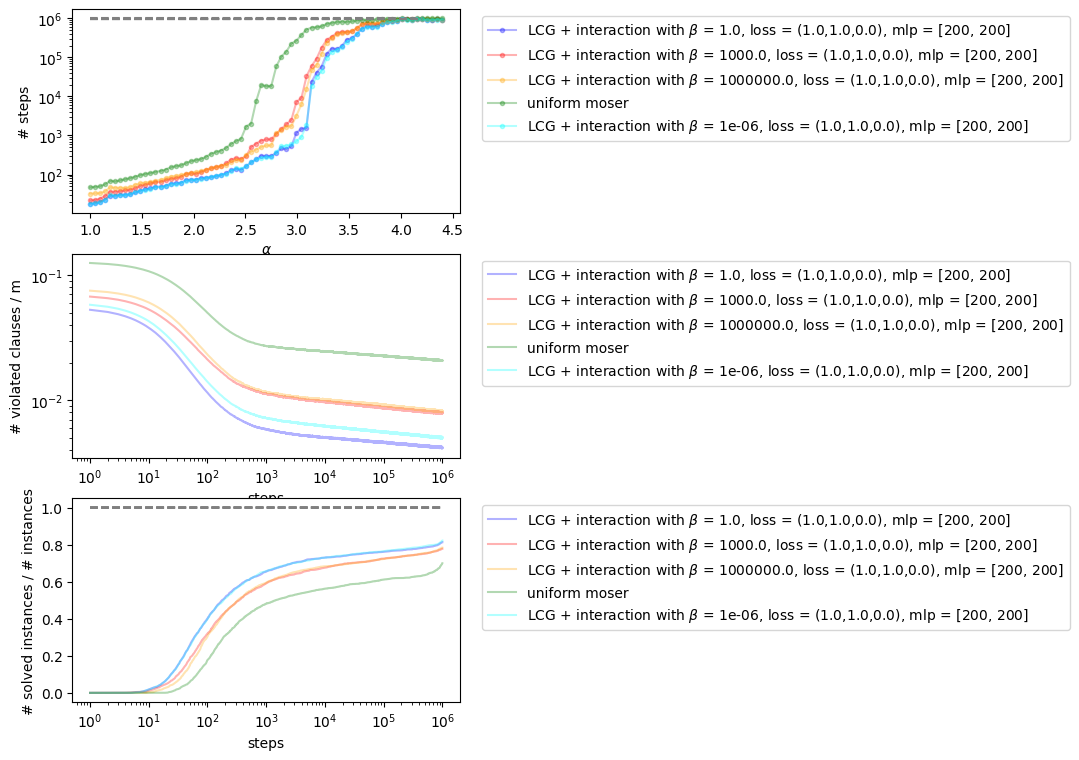

In [49]:
saved_eval_path_list = ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/new_random_3SAT220230726-062137moser.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/new_random_3SAT20230712-111354version_new_random_3SAT_vary_zero.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/new_random_3SAT20230712-095319version_new_random_3SAT_vary_zero.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/uniformversion_uniform_moser_TEST_NEWWWW.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW.npy"]
color = ["blue", "red", "orange", "green", "cyan", "teal", "yellow", "lightgreen", "salmon","gray", "black"]
#x = np.linspace(1, 4.4, 18)
x = np.linspace(1, 4.4, 71)
x_vary = 0.05
plot_save = False # "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW3"
do_evaluation_multiple_models_overview(saved_eval_path_list, color, average_alpha = (x, x_vary), plot_save = False)



total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)


/var/folders/_5/jp84zrhn28sg9yqq0sq0dkfr0000gp/T/ipykernel_40576/3489012561.py:328: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


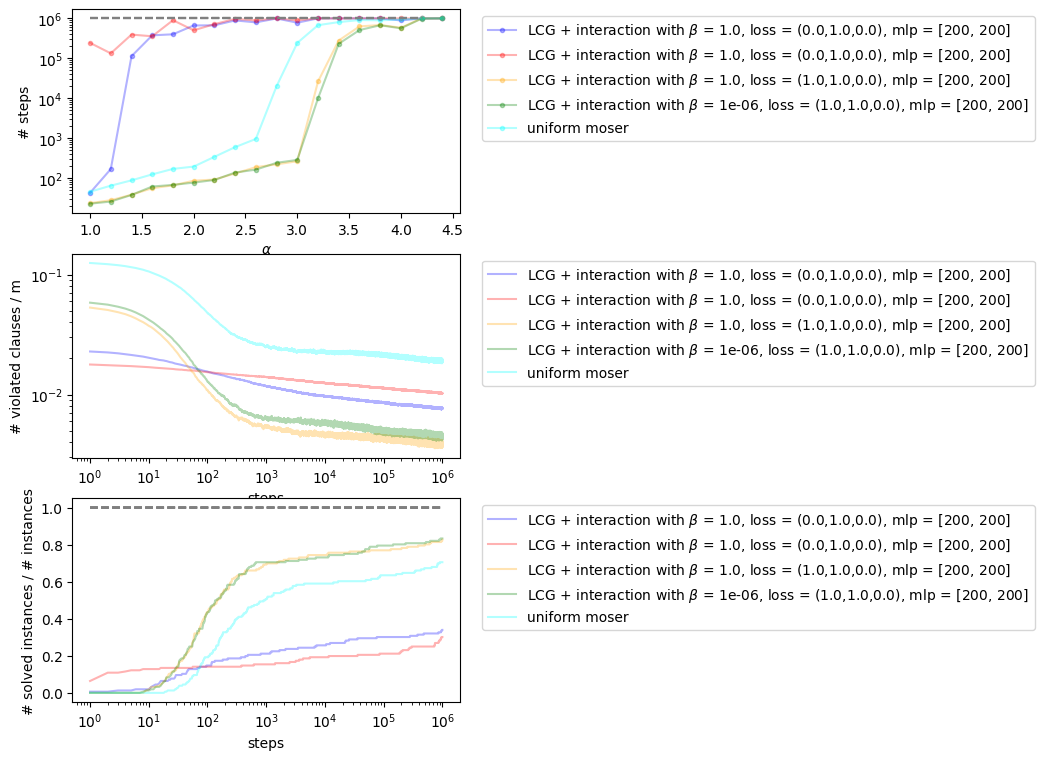

In [50]:
saved_eval_path_list = ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT220230726-131559moser.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT220230725-155637moser.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT220230726-062137moser.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_5.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/uniformversion_new_random_3SAT.npy"]
color = ["blue", "red", "orange", "green", "cyan", "teal", "yellow", "lightgreen", "salmon","gray", "black"]
x = np.linspace(1, 4.4, 18)
#x = np.linspace(1, 4.4, 71)
x_vary = 0.05
plot_save = False # "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW3"
do_evaluation_multiple_models_overview(saved_eval_path_list, color, average_alpha = (x, x_vary), plot_save = False)


total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)


/var/folders/_5/jp84zrhn28sg9yqq0sq0dkfr0000gp/T/ipykernel_40576/3682766728.py:322: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


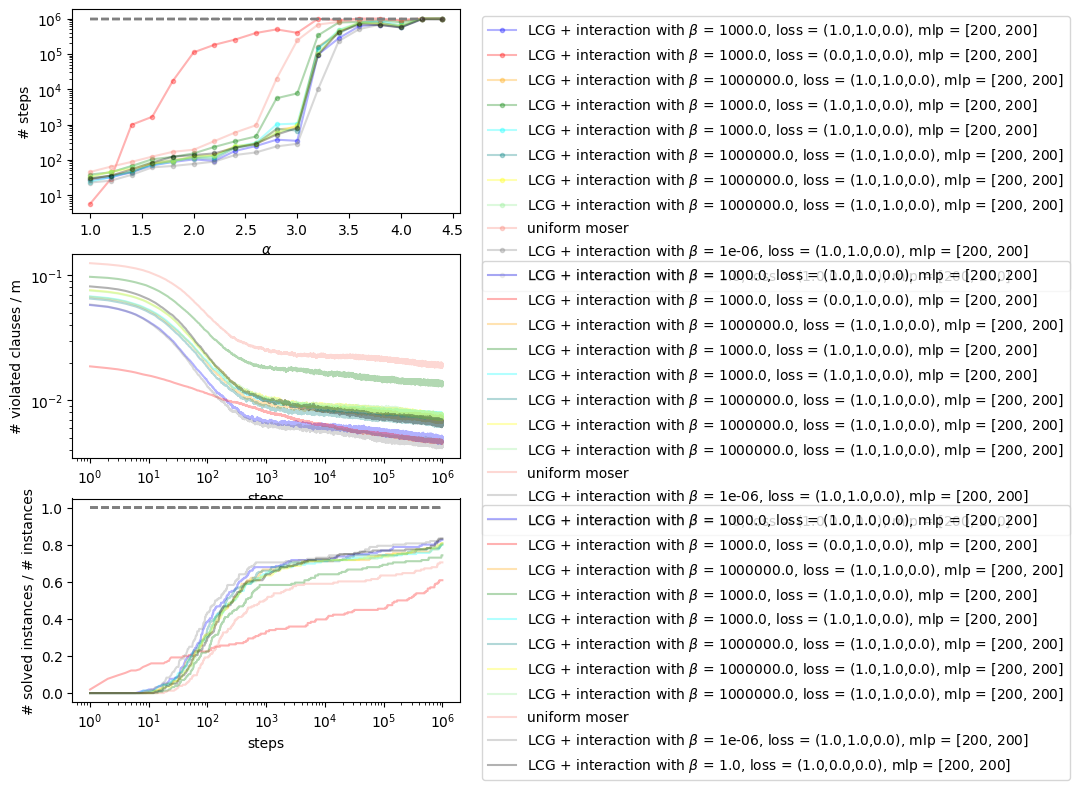

In [2]:
saved_eval_path_list = ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT20230713-115659version_new_random_3SAT.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT20230713-113031version_new_random_3SAT.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT20230713-124028version_new_random_3SAT.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT20230712-185249version_new_random_3SAT.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT20230712-111354version_new_random_3SAT.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT20230712-125022version_new_random_3SAT.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT20230712-122336version_new_random_3SAT.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT20230712-095319version_new_random_3SAT.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/uniformversion_new_random_3SAT.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_5.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT220230725-133615version_uniform_moser_TEST_NEWWWW_10_6_5.npy"]
color = ["blue", "red", "orange", "green", "cyan", "teal", "yellow", "lightgreen", "salmon","gray", "black"]
x = np.linspace(1, 4.4, 18)
x_vary = 0.05
plot_save = False # "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW3"
do_evaluation_multiple_models_overview(saved_eval_path_list, color, average_alpha = (x, x_vary), plot_save = False)



total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)


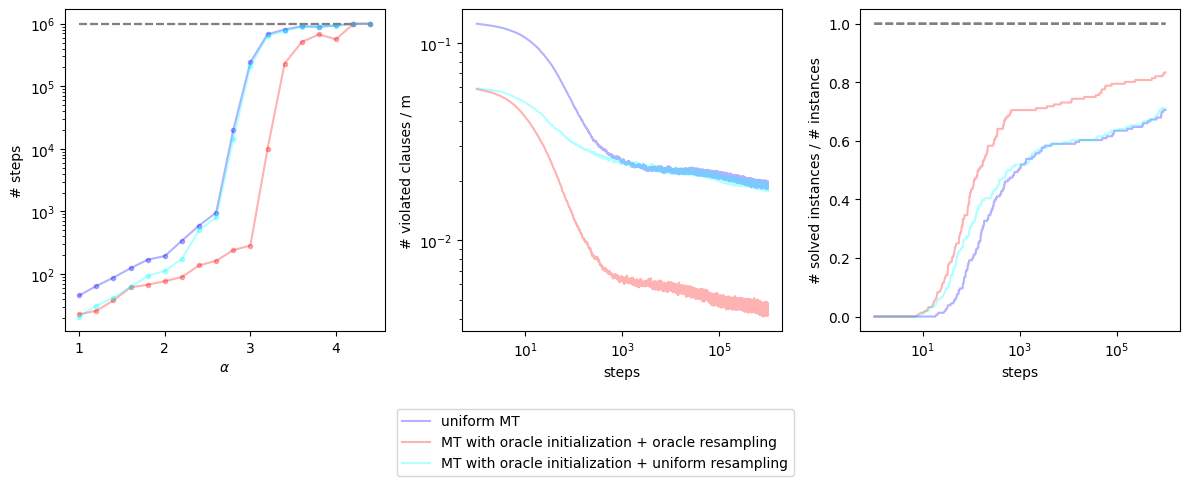

In [43]:


saved_eval_path_list = ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/uniformversion_new_random_3SAT.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_5.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_model_initialize_uniform_resample.npy",]
color = ["blue", "red", "cyan",]
legend = ["uniform MT", "MT with oracle initialization + oracle resampling","MT with oracle initialization + uniform resampling"]
x = np.linspace(1, 4.4, 18)
x_vary = 0.05
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_moser_init"
do_evaluation_multiple_models_paper_legend(saved_eval_path_list, color, average_alpha = (x, x_vary), plot_save = plot_save, legend=legend)




total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)


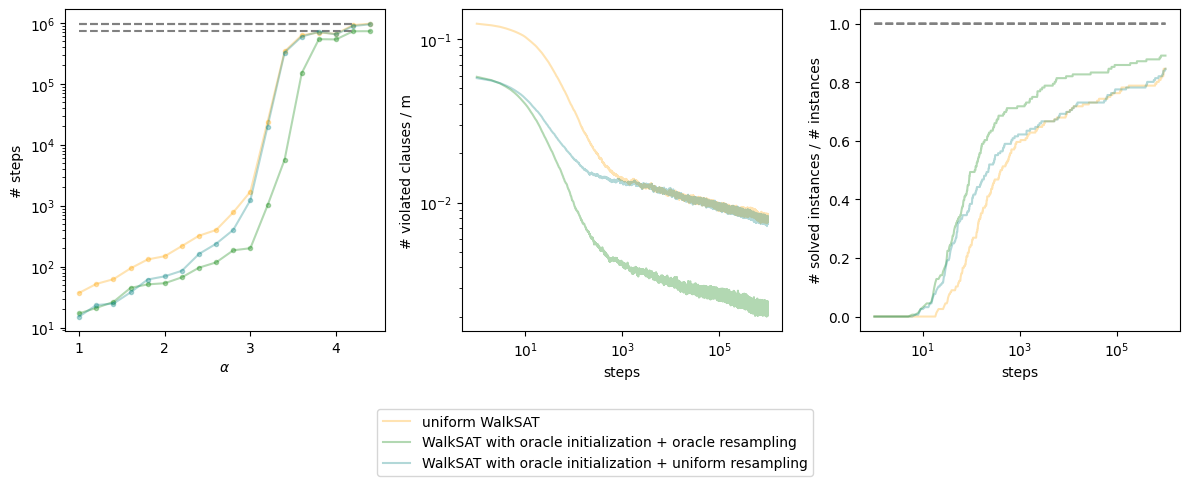

In [45]:


saved_eval_path_list = ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/schoeningschoening_both.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328probsat_version_model_initialize_and_resample.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328probsat_version_model_initialize_uniform_resample.npy",]
color = ["orange", "green", "teal"]

legend = ["uniform WalkSAT", "WalkSAT with oracle initialization + oracle resampling","WalkSAT with oracle initialization + uniform resampling"]
x = np.linspace(1, 4.4, 18)
x_vary = 0.05
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_walksat_init"
do_evaluation_multiple_models_paper_legend(saved_eval_path_list, color, average_alpha = (x, x_vary), plot_save = plot_save, legend=legend)




total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)


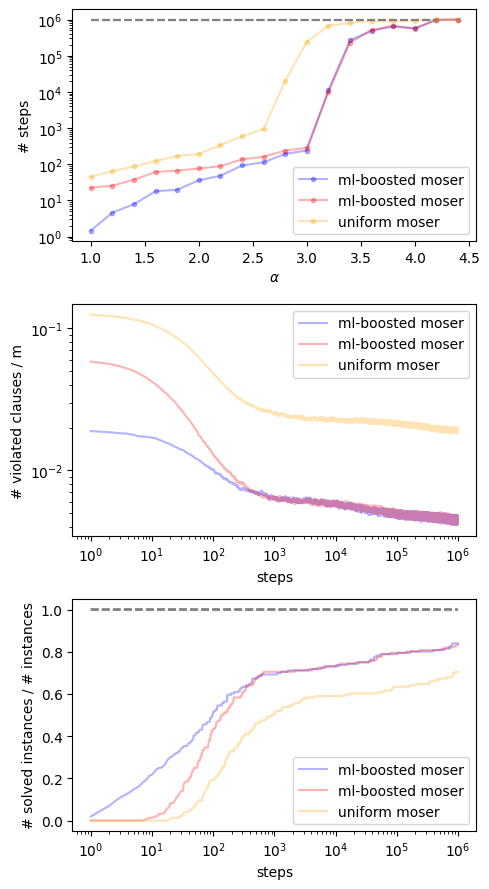

In [8]:


saved_eval_path_list = ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT20230713-113031moser_version_LLL_initialize_and_LLL_DM_resample.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_5.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/uniformversion_new_random_3SAT.npy",]
color = ["blue", "red", "orange", "green", "cyan", "teal", "yellow", "lightgreen", "salmon","gray", "black"]
x = np.linspace(1, 4.4, 18)
x_vary = 0.05
plot_save = False # "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW3"
do_evaluation_multiple_models_paper(saved_eval_path_list, color, average_alpha = (x, x_vary), plot_save = False)



total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 5)
total_steps_mean (156,)


/var/folders/_5/jp84zrhn28sg9yqq0sq0dkfr0000gp/T/ipykernel_40576/51430696.py:229: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML3/ml_based_sat_solver/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


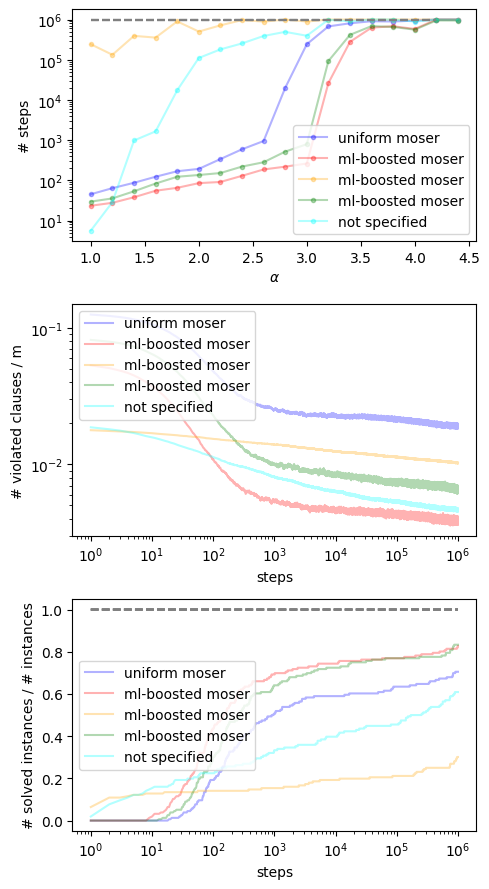

In [10]:


saved_eval_path_list = ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/uniformversion_new_random_3SAT.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT220230726-062137moser.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT220230725-155637moser.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT220230725-133615version_uniform_moser_TEST_NEWWWW_10_6_5.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT20230713-113031version_new_random_3SAT.npy",]
color = ["blue", "red", "orange", "green", "cyan", "teal", "yellow", "lightgreen", "salmon","gray", "black"]
x = np.linspace(1, 4.4, 18)
x_vary = 0.05
plot_save = False # "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW3"
do_evaluation_multiple_models_paper(saved_eval_path_list, color, average_alpha = (x, x_vary), plot_save = False)



In [ ]:

saved_eval_path_list = ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/uniformversion_new_random_3SAT.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT220230726-062137moser.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT220230725-155637moser.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT220230725-133615version_uniform_moser_TEST_NEWWWW_10_6_5.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/new_random_3SAT20230713-113031version_new_random_3SAT.npy",]
color = ["blue", "red", "orange", "green", "cyan", "teal", "yellow", "lightgreen", "salmon","gray", "black"]
x = np.linspace(1, 4.4, 18)
x_vary = 0.05
plot_save = False # "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW3"
do_evaluation_multiple_models_paper(saved_eval_path_list, color, average_alpha = (x, x_vary), plot_save = False)


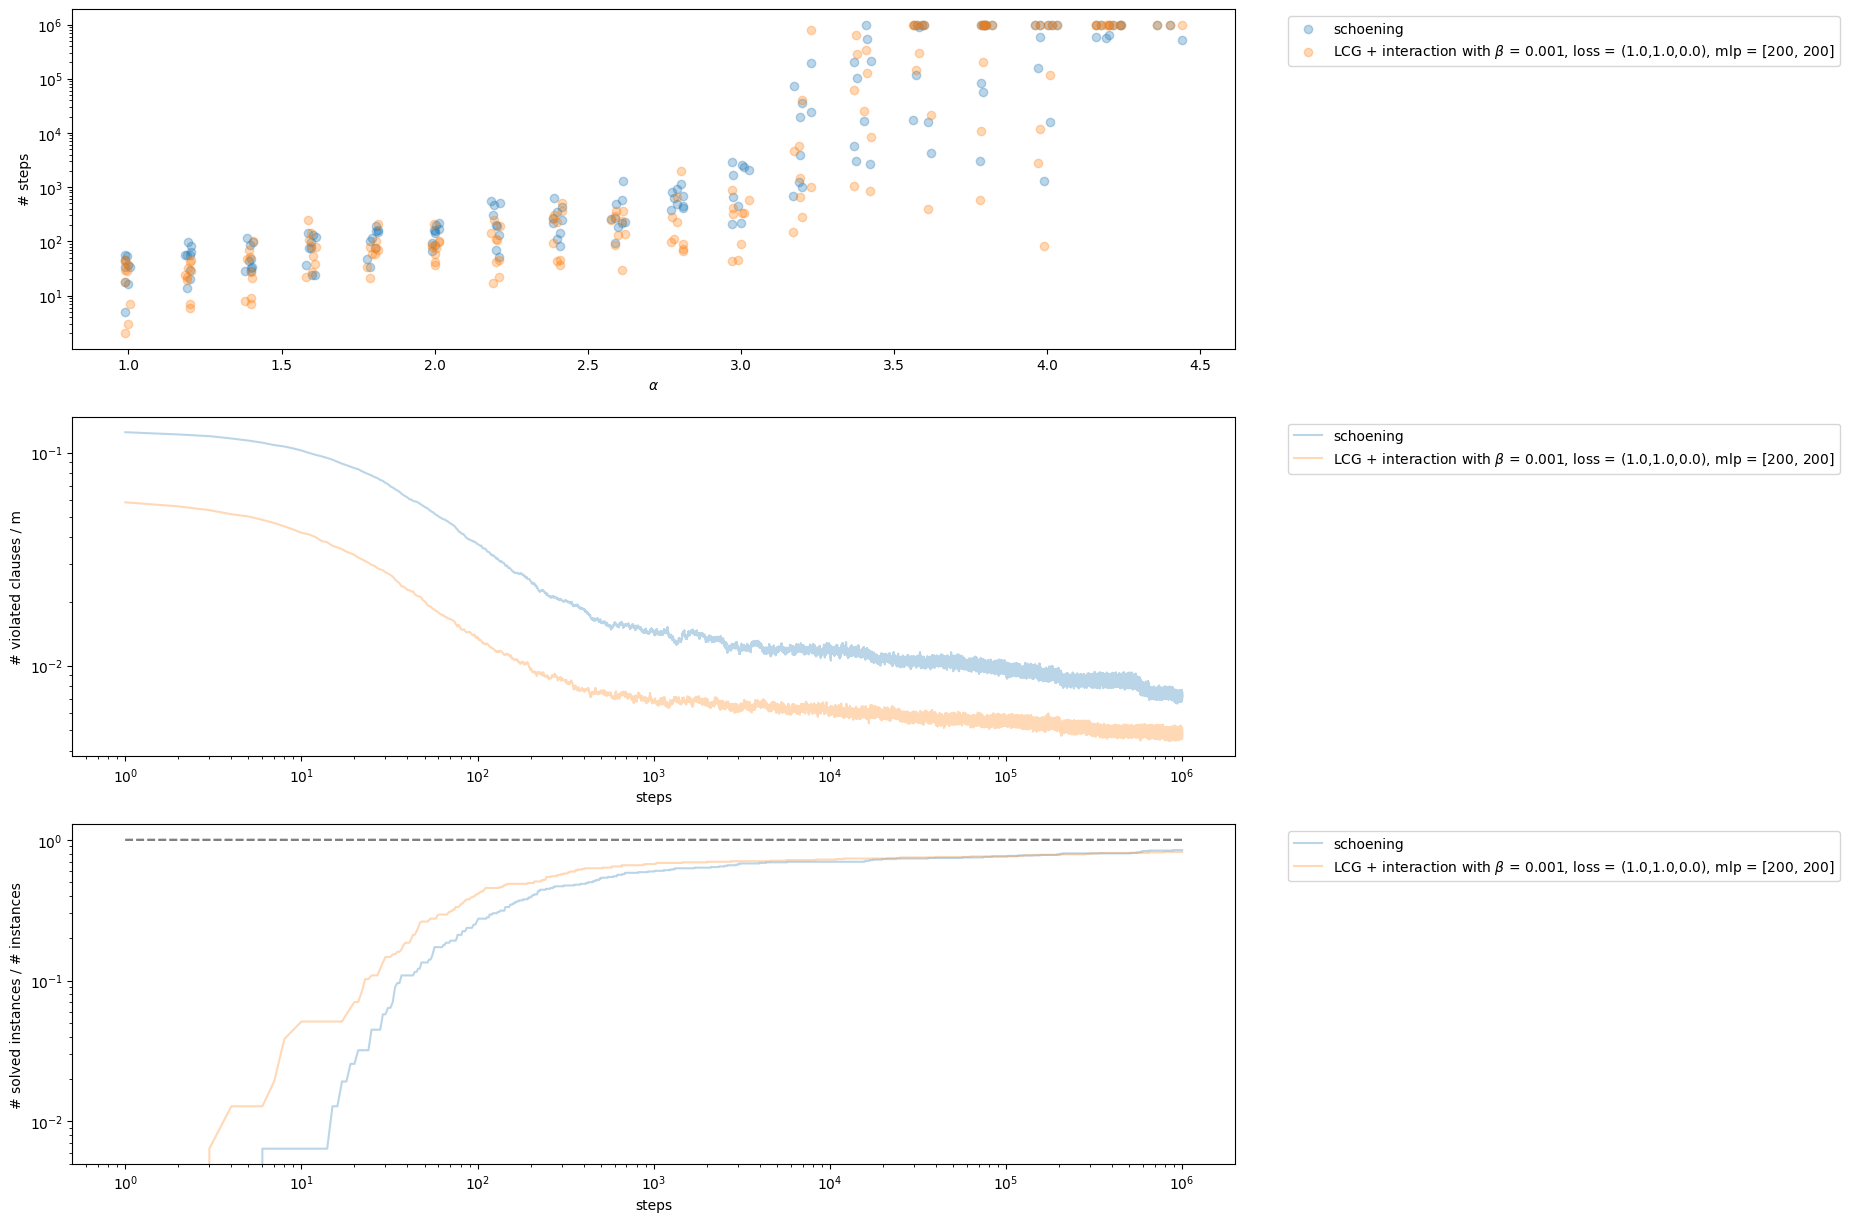

In [66]:
#saved_eval_path_list = ["/Users/p403830/Downloads/samples_random_3SAT/uniform_total_eval_EVALUATION_SET.npy",
#                        "/Users/p403830/Downloads/samples_random_3SAT/schoening_total_eval_EVALUATION.npy",
saved_eval_path_list=  [#"/Users/p403830/Downloads/samples_random_3SAT/uniform.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/schoening2.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/samples_random_3SAT_evaluationbenchmark_LCG_VCG_3SAT20230530-155713.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/samples_random_3SAT_evaluationbenchmark_LCG_VCG_3SAT20230530-122213.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230531-032807.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230530-214741.npy",

                        ]
do_evaluation_multiple_models(saved_eval_path_list)

#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha")  

In [1]:
import numpy as np
x = np.load("/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_n300_subset/random_3SAT20230530-134743_total_eval.npy", allow_pickle=True)

ModuleNotFoundError: No module named 'python'

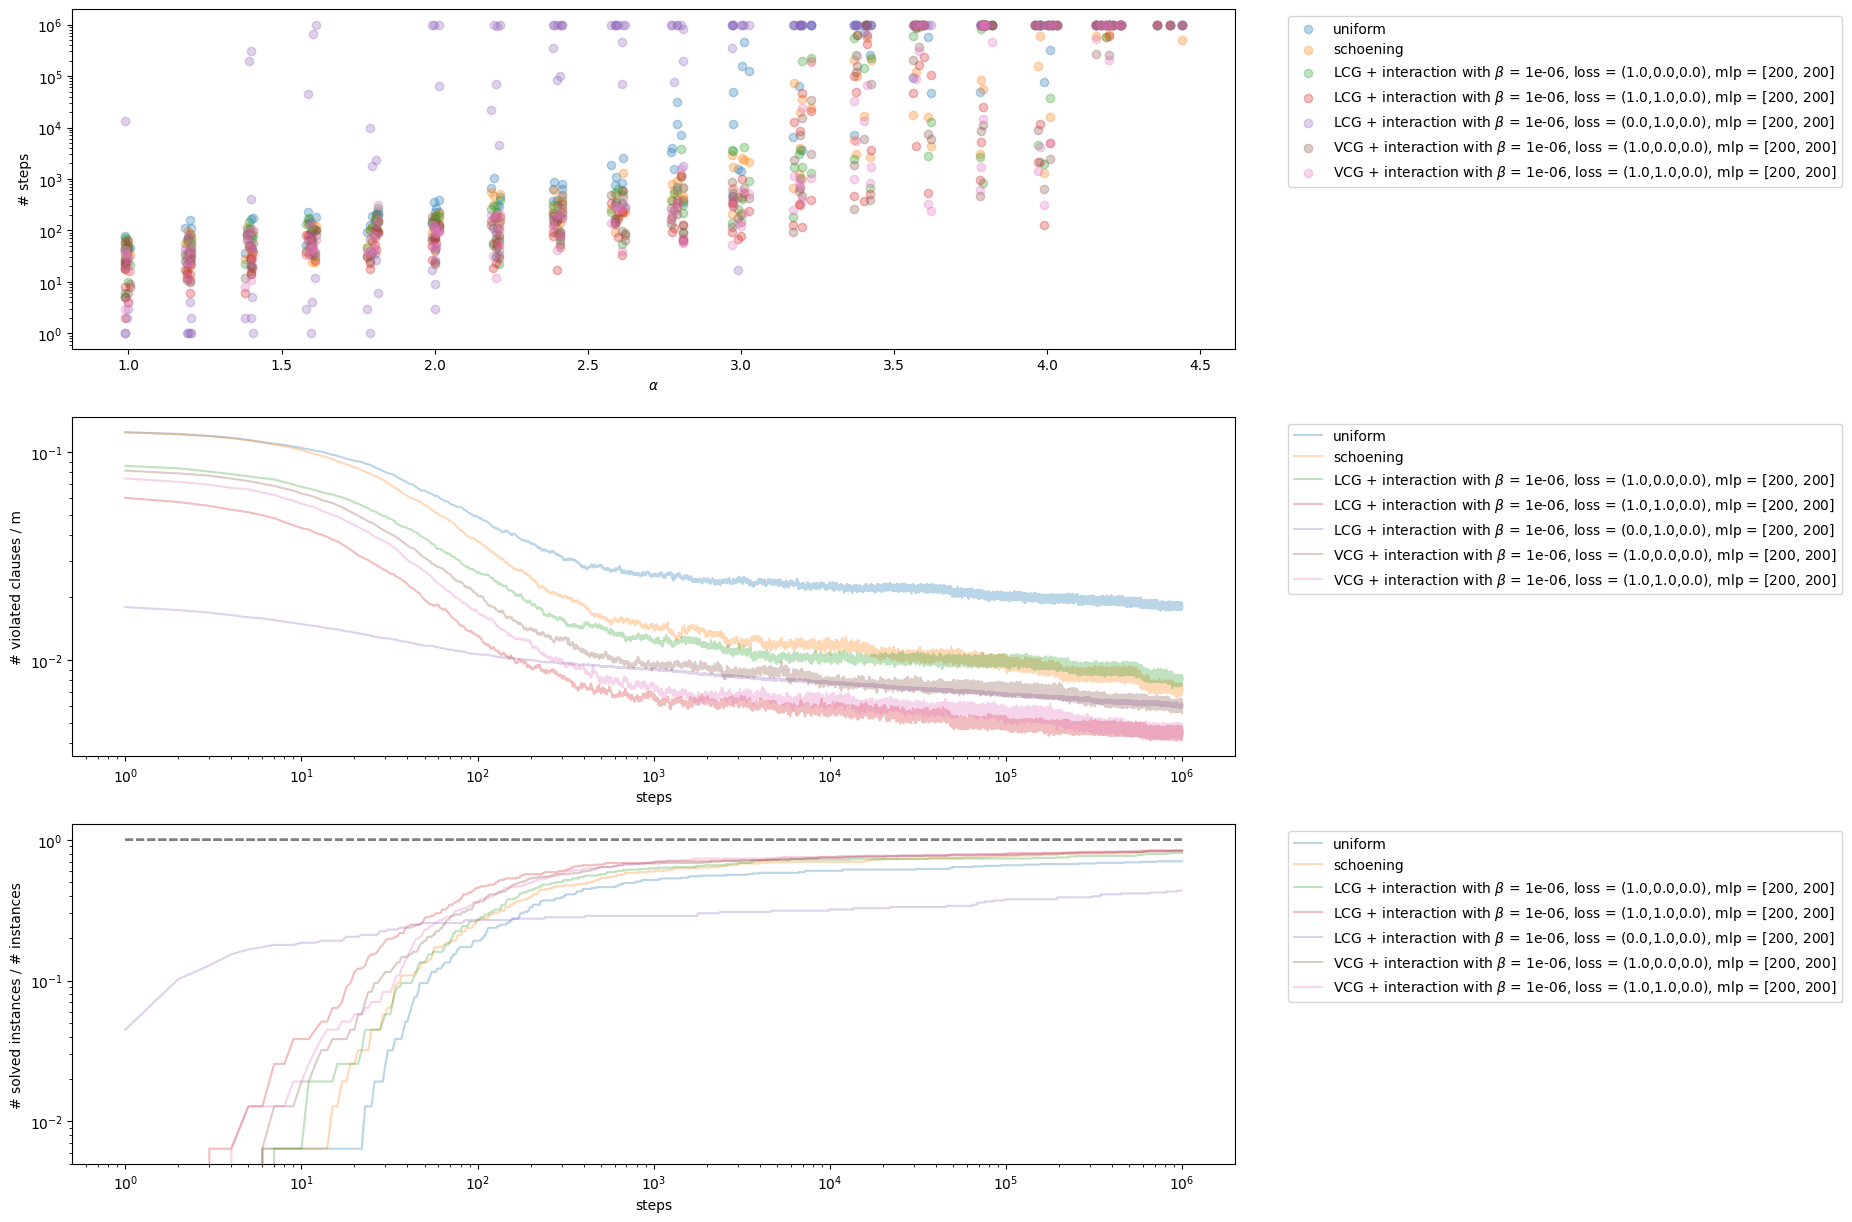

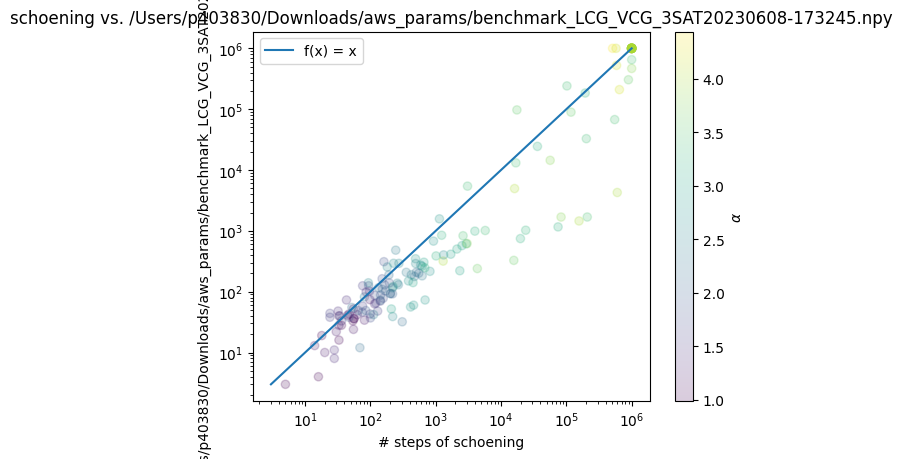

In [13]:
#saved_eval_path_list = ["/Users/p403830/Downloads/samples_random_3SAT/uniform_total_eval_EVALUATION_SET.npy",
#                        "/Users/p403830/Downloads/samples_random_3SAT/schoening_total_eval_EVALUATION.npy",
saved_eval_path_list=  ["/Users/p403830/Downloads/samples_random_3SAT/uniform.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/schoening2.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-095324.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230602-011857.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-084252.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-101328.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-132014.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-162001.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-172452.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-182806.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-184357.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-223200.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-213309.npy"
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230608-173245.npy",
                        ]
do_evaluation_multiple_models(saved_eval_path_list)

#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        # benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha") 

benchmark_two_models(saved_eval_path_list[1], saved_eval_path_list[6], color_coded = "alpha") 

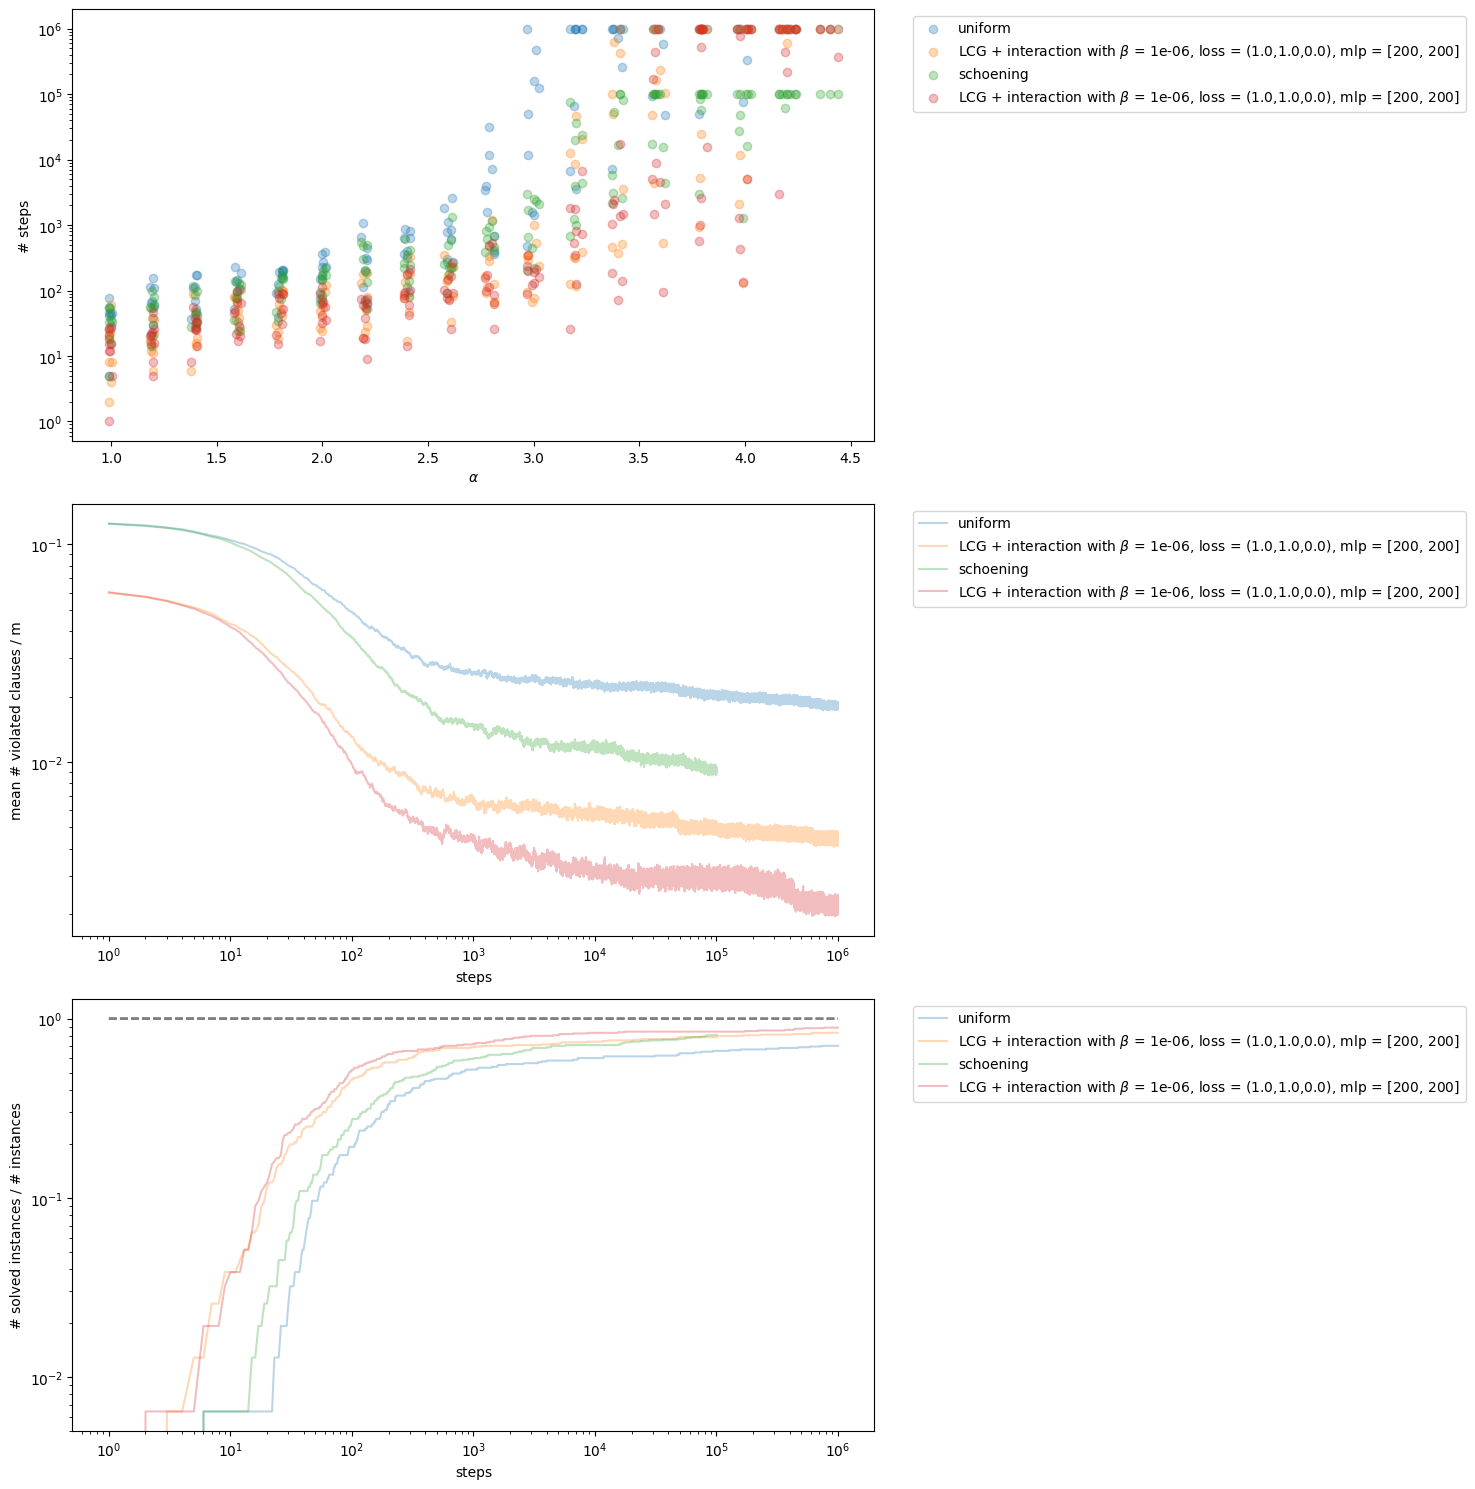

In [13]:
#saved_eval_path_list=["/Users/p403830/Downloads/samples_random_3SAT/schoeningversion_schoening.npy",
#                      # "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-101328version_probsat.npy",
#                      "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-101328version_probsat2.npy",
#                      "/Users/p403830/Downloads/samples_random_3SAT/uniform.npy",
#                      "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-101328.npy",
#                        ]


saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/uniform.npy", #uniformEVAL_NEW___.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/schoeningEVAL_NEW___2.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_probsat2.npy"
                        
                        ]
do_evaluation_multiple_models(saved_eval_path_list)


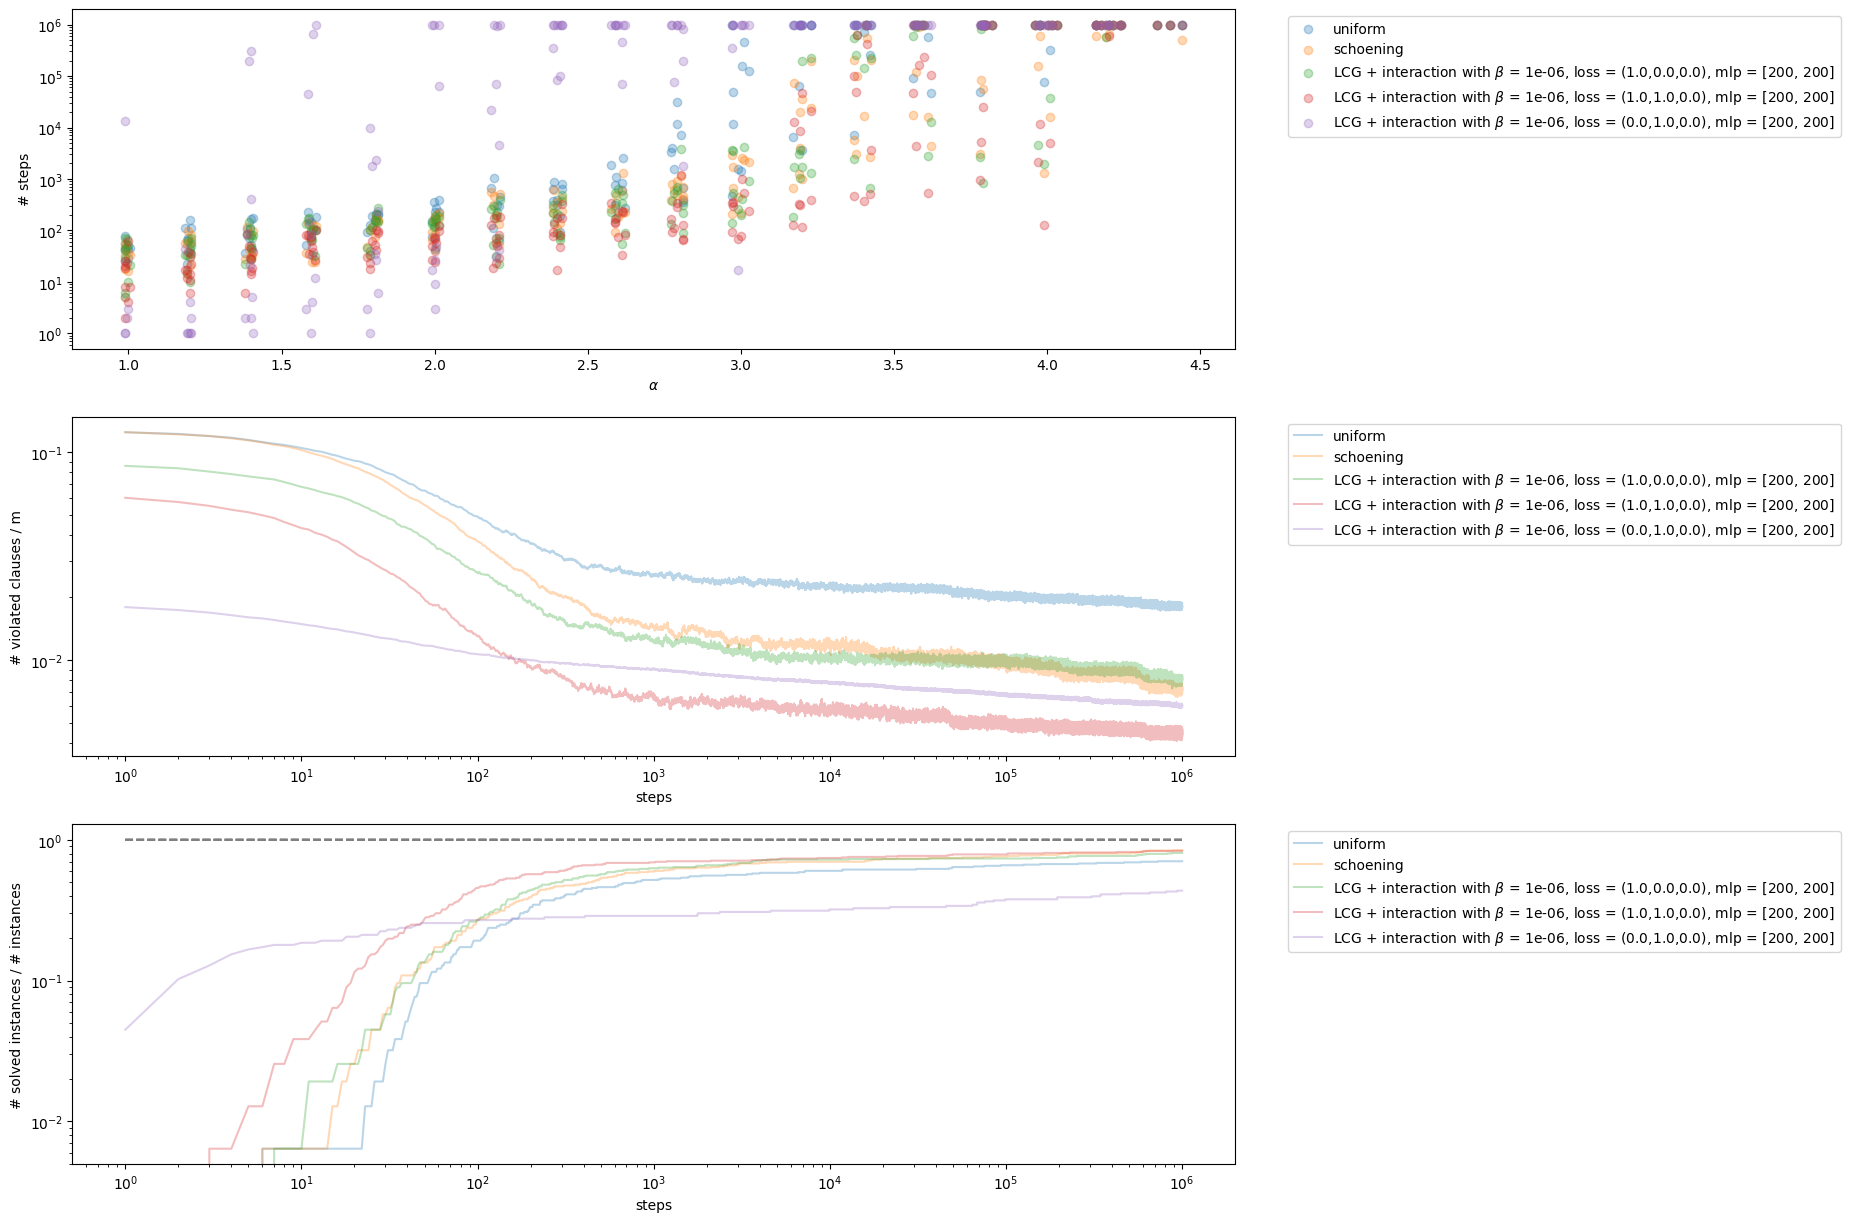

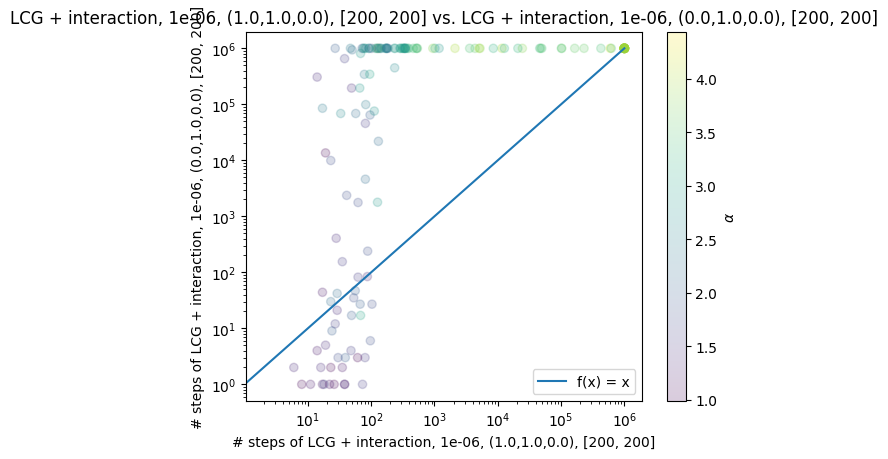

In [68]:
#saved_eval_path_list = ["/Users/p403830/Downloads/samples_random_3SAT/uniform_total_eval_EVALUATION_SET.npy",
#                        "/Users/p403830/Downloads/samples_random_3SAT/schoening_total_eval_EVALUATION.npy",
saved_eval_path_list=  ["/Users/p403830/Downloads/samples_random_3SAT/uniform.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/schoening2.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-095324.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230602-011857.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-084252.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-101328.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-132014.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-162001.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-172452.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-182806.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-184357.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-223200.npy",
                        ]
do_evaluation_multiple_models(saved_eval_path_list)

#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        # benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha") 

benchmark_two_models(saved_eval_path_list[3], saved_eval_path_list[4], color_coded = "alpha") 

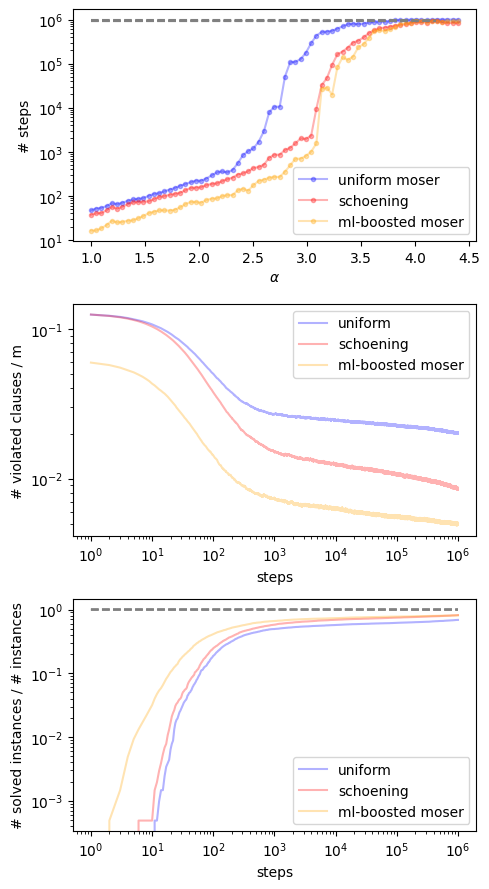

In [72]:

saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/uniform_total_eval_EVALUATION.npy",
                        #"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/schoening_total_eval_EVALUATION.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/samples_random_3SAT_evaluation_vary_zeroschoening2.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/EVALbenchmark_LCG_VCG_3SAT20230601-101328.npy",
                        ]
color = ["blue", "red", "orange"]
#x = np.linspace(1, 4.4, 71)
x = np.linspace(1, 4.4, 71)
x_vary = 0.05
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW"
# do_evaluation_multiple_models(saved_eval_path_list)
do_evaluation_multiple_models_paper(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)

#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        # benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha") 

#benchmark_two_models(saved_eval_path_list[3], saved_eval_path_list[4], color_coded = "alpha") 

total_steps (2052, 10)
total_steps_mean (2052,)
total_steps (2052, 10)
total_steps_mean (2052,)
total_steps (2052, 10)
total_steps_mean (2052,)
total_steps (2052, 10)
total_steps_mean (2052,)


/var/folders/_5/jp84zrhn28sg9yqq0sq0dkfr0000gp/T/ipykernel_7116/1781525568.py:223: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/var/folders/_5/jp84zrhn28sg9yqq0sq0dkfr0000gp/T/ipykernel_7116/1781525568.py:225: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(plot_save + ".png", dpi = 300, format = "png")
/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML3/ml_based_sat_solver/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


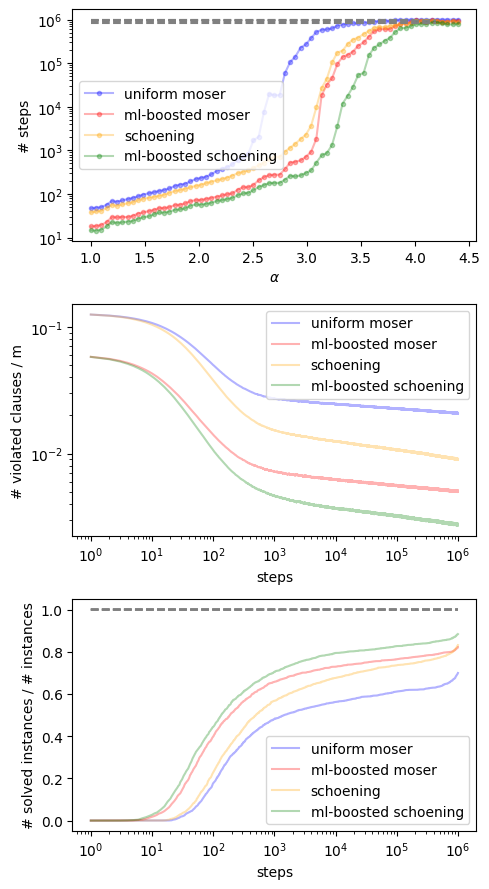

In [39]:

saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/uniformversion_uniform_moser_TEST_NEWWWW.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/schoeningversion_uniform_moser_TEST_NEWWWW.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/benchmark_LCG_VCG_3SAT20230601-101328version_probsat_TEST_NEWWWW.npy",
                        
                        ]
color = ["blue", "red", "orange","green"]
x = np.linspace(1, 4.4, 71)
x_vary = 0.05
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW3"
do_evaluation_multiple_models_paper(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)

total_steps (156, 5)
total_steps_mean (156,)
total_steps (156, 10)
total_steps_mean (156,)
total_steps (156, 20)
total_steps_mean (156,)
total_steps (156, 50)
total_steps_mean (156,)


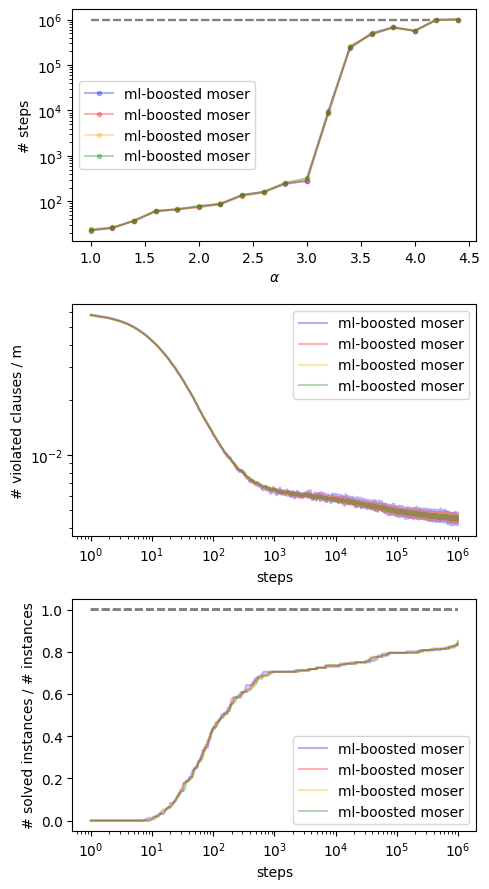

In [4]:

saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_5.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_10.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_20.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_50.npy",
                        
                        ]
color = ["blue", "red", "orange","green"]
x = np.linspace(1, 4.4, 18)
x_vary = 0.05
plot_save = False # "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW3"
do_evaluation_multiple_models_paper(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)

total_steps (156, 5)
total_steps_mean (156,)


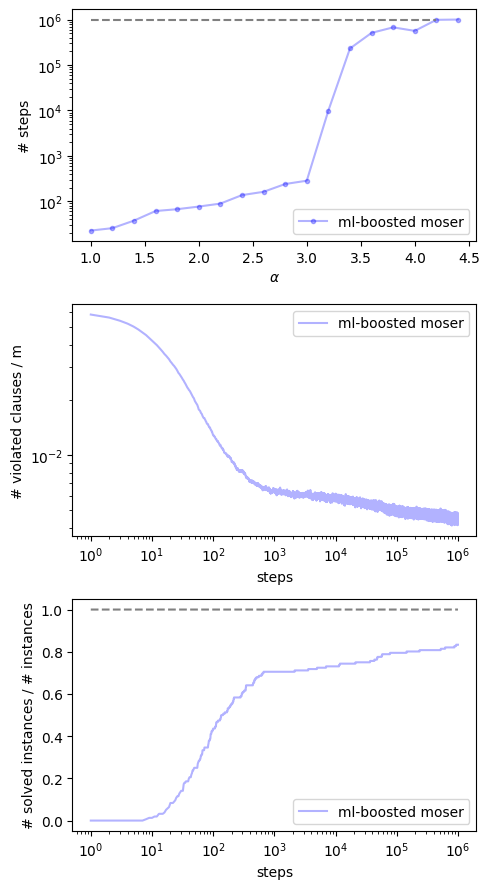

In [5]:

saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_5.npy",
                        #"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_10.npy",
                        #"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_20.npy",
                        #"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_50.npy",
                        
                        ]
color = ["blue", "red", "orange","green"]
x = np.linspace(1, 4.4, 18)
x_vary = 0.05
plot_save = False # "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW3"
do_evaluation_multiple_models_paper(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)

total_steps (156, 50)
total_steps_mean (156,)


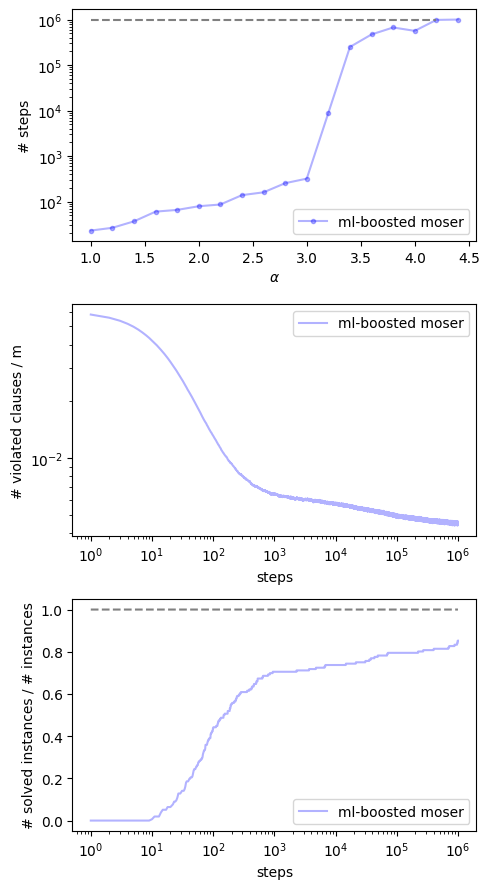

In [7]:

saved_eval_path_list=  [#"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_5.npy",
                        #"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_10.npy",
                        #"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_20.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW_10_6_50.npy",
                        
                        ]
color = ["blue", "red", "orange","green"]
x = np.linspace(1, 4.4, 18)
x_vary = 0.05
plot_save = False # "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW3"
do_evaluation_multiple_models_paper(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)

(1, 2052)
(1, 2052)


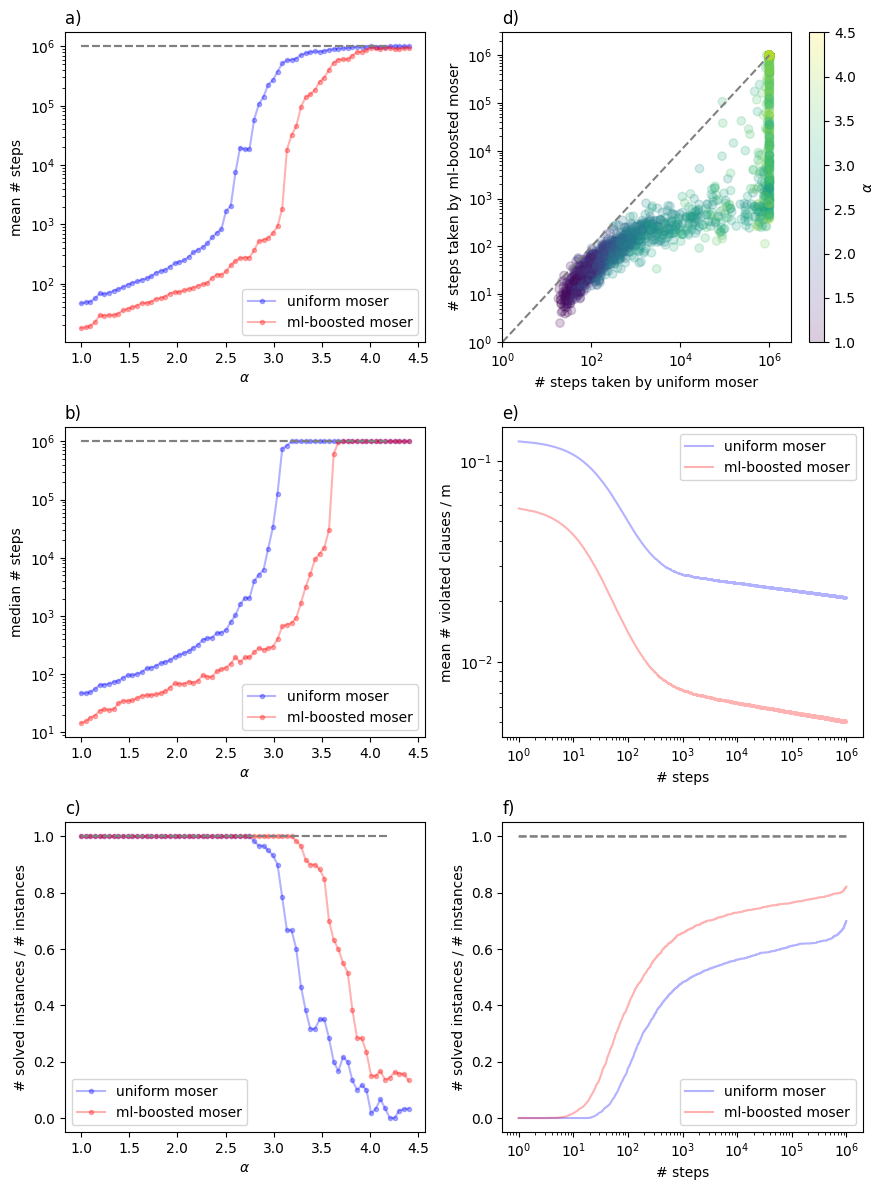

In [48]:
saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/uniformversion_uniform_moser_TEST_NEWWWW.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW.npy",
                        #"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/schoeningversion_uniform_moser_TEST_NEWWWW.npy",
                        #"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/benchmark_LCG_VCG_3SAT20230601-101328version_probsat_TEST_NEWWWW.npy",
                        
                        ]
color = ["blue", "red"]
x = np.linspace(1, 4.4, 71)
x_vary = 0.05
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW2"
do_evaluation_multiple_models_paper2(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)

(1, 2052)
(1, 2052)


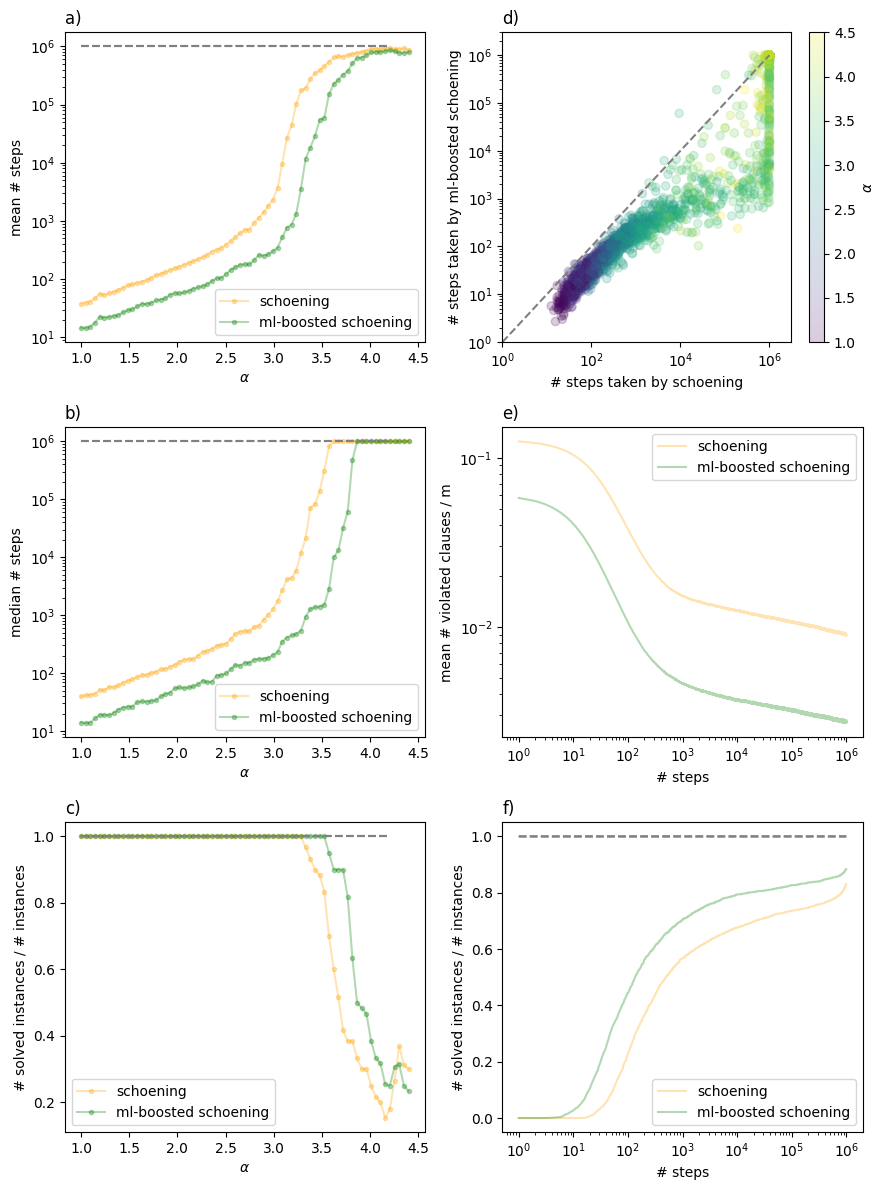

In [45]:
saved_eval_path_list=  [#"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/uniformversion_uniform_moser_TEST_NEWWWW.npy",
                        #"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/benchmark_LCG_VCG_3SAT20230601-101328version_uniform_moser_TEST_NEWWWW.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/schoeningversion_uniform_moser_TEST_NEWWWW.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/benchmark_LCG_VCG_3SAT20230601-101328version_probsat_TEST_NEWWWW.npy",
                        
                        ]
color = ["orange","green"]
x = np.linspace(1, 4.4, 71)
x_vary = 0.05
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW2_schoening"
do_evaluation_multiple_models_paper2(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save, mode = "schoening")

/var/folders/_5/jp84zrhn28sg9yqq0sq0dkfr0000gp/T/ipykernel_7116/4233162737.py:305: RuntimeWarning: invalid value encountered in scalar divide
  y_percentage.append(np.sum(np.where(relevant_steps_mean<maxsteps - 1, 1, 0))/len(relevant_steps_mean))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1, 17)
(1, 17)


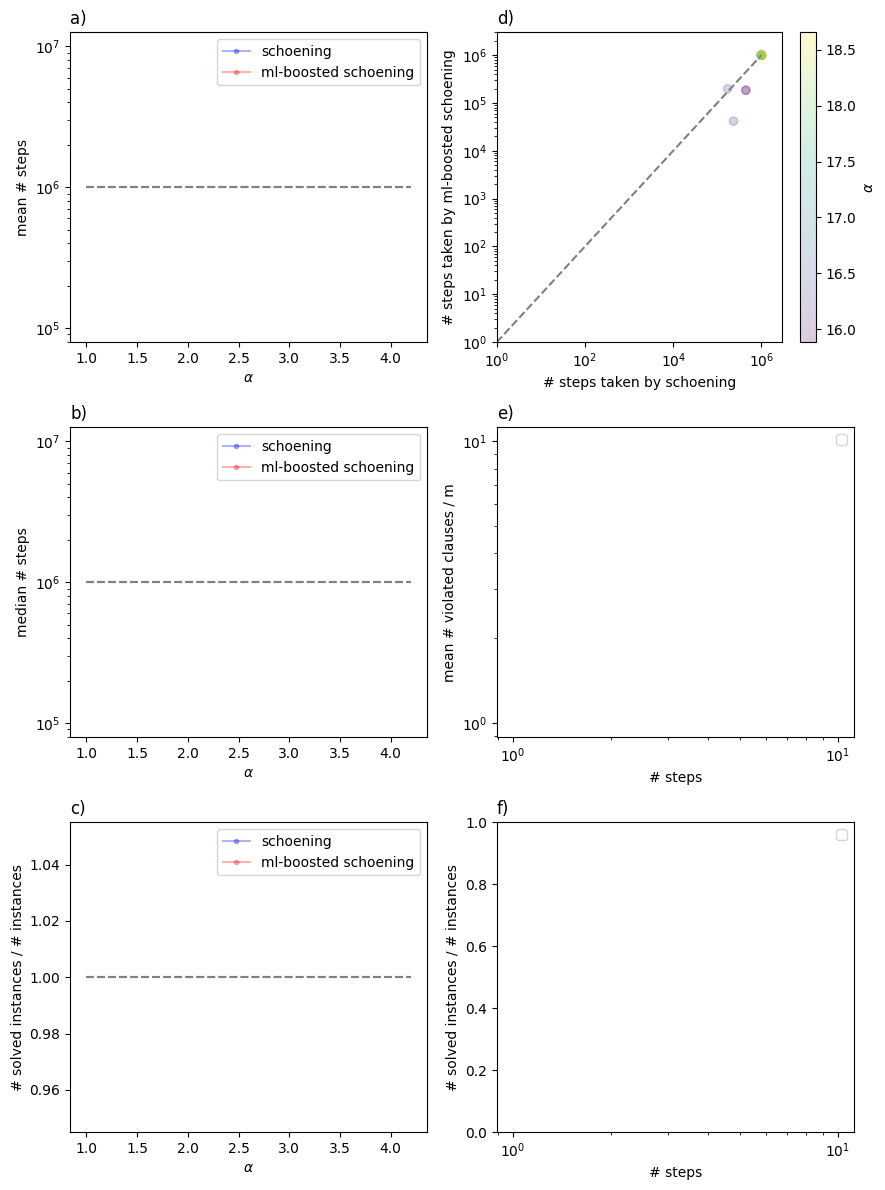

In [44]:
saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/ml_based_sat_solver/BroadcastTestSet_subset/schoening_total_eval_schoening_NO_TRAJ.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/ml_based_sat_solver/BroadcastTestSet_subset/benchmark_LCG_VCG_3SAT20230601-101328_total_eval_probsat_NO_TRAJ.npy",
                        
                        ]
color = ["blue", "red", "orange","green"]
x = np.linspace(1, 4.4, 71)
x_vary = 0.05
plot_save = False # "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW"
do_evaluation_multiple_models_paper2(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save, mode="schoening")

/var/folders/_5/jp84zrhn28sg9yqq0sq0dkfr0000gp/T/ipykernel_30505/2792663798.py:197: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/var/folders/_5/jp84zrhn28sg9yqq0sq0dkfr0000gp/T/ipykernel_30505/2792663798.py:199: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(plot_save + ".png", dpi = 300, format = "png")


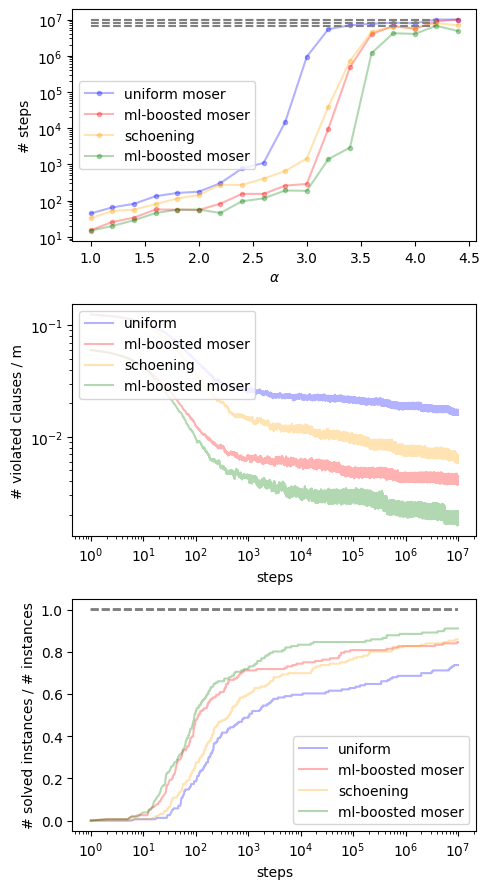

In [22]:
saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/uniformversion_moser3.npy", #uniformEVAL_NEW___.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_moser3.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/schoeningversion_moser.npy", #schoeningEVAL_NEW___2.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_probsat3.npy" #benchmark_LCG_VCG_3SAT20230601-101328version_probsat2.npy"
                        
                        ]
color = ["blue", "red", "orange", "green"]
#x = np.linspace(1, 4.4, 71)
x = np.linspace(1, 4.4, 18)
x_vary = 0.05
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_NEW_PROBSAT"
do_evaluation_multiple_models_paper(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)



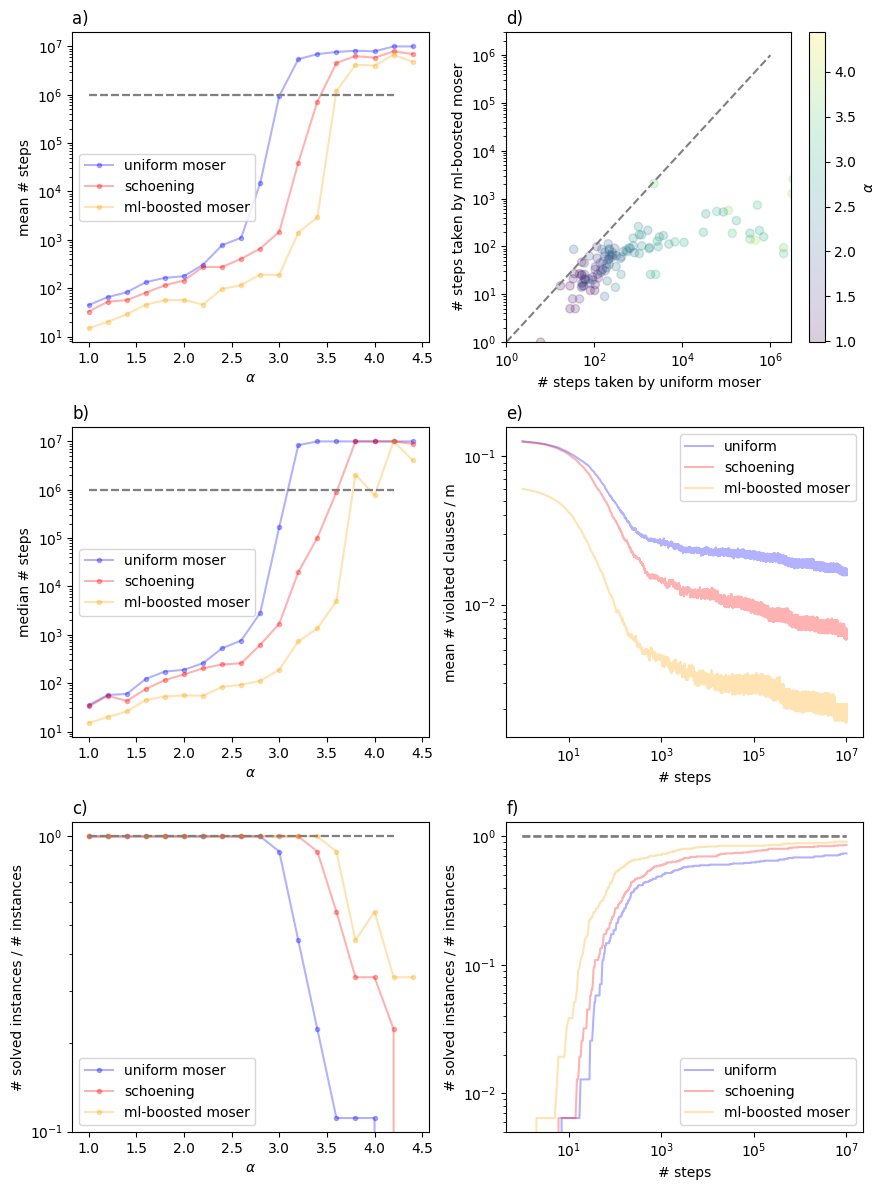

In [26]:

saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/uniformversion_moser3.npy", #uniformEVAL_NEW___.npy",
                        #"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_moser3.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/schoeningversion_moser.npy", #schoeningEVAL_NEW___2.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230601-101328version_probsat3.npy",
                        ]
color = ["blue", "red", "orange"]
#x = np.linspace(1, 4.4, 71)
x = np.linspace(1, 4.4, 18)
x_vary = 0.05
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_probsat"
# do_evaluation_multiple_models(saved_eval_path_list)
do_evaluation_multiple_models_paper2(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)

#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        # benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha") 

#benchmark_two_models(saved_eval_path_list[3], saved_eval_path_list[4], color_coded = "alpha") 

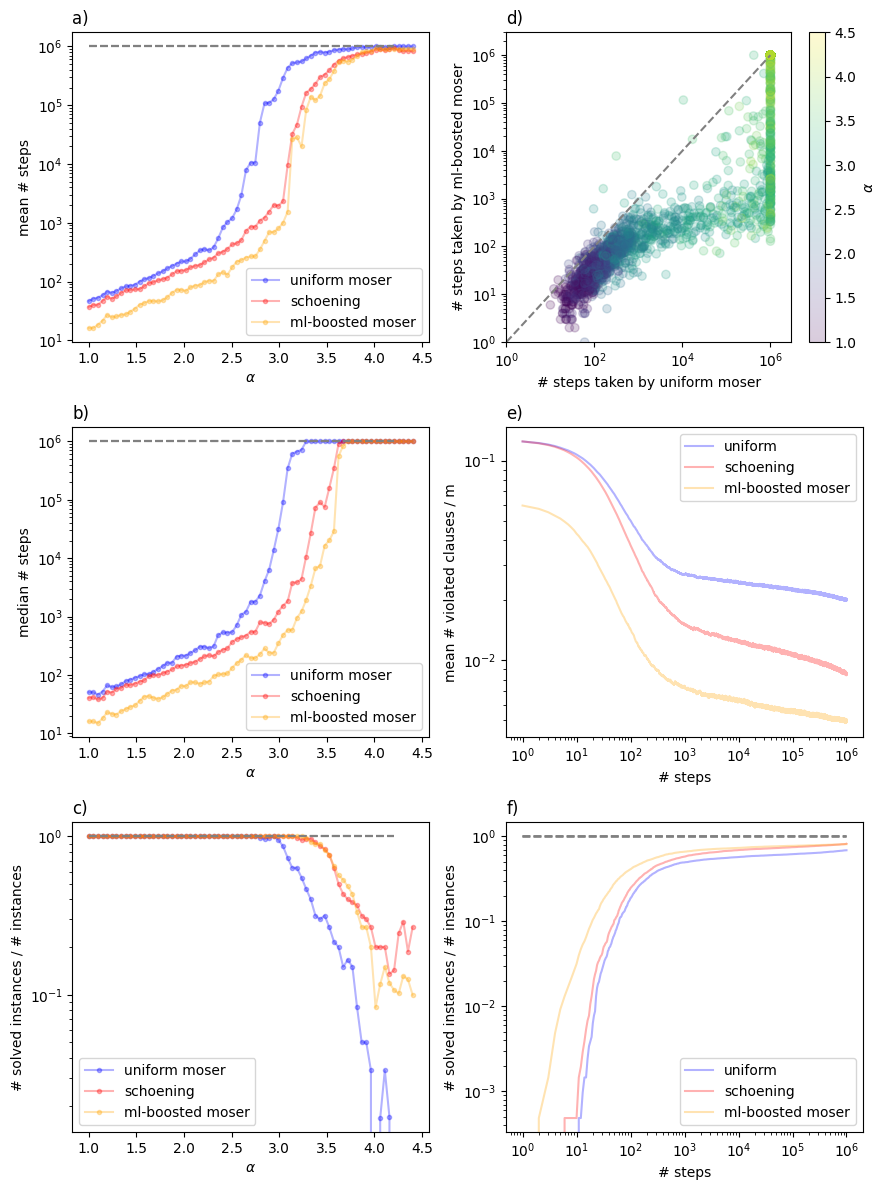

In [71]:

saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/uniform_total_eval_EVALUATION.npy",
                        #"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/schoening_total_eval_EVALUATION.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/samples_random_3SAT_evaluation_vary_zeroschoening2.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/EVALbenchmark_LCG_VCG_3SAT20230601-101328.npy",
                        ]
color = ["blue", "red", "orange"]
#x = np.linspace(1, 4.4, 71)
x = np.linspace(1, 4.4, 71)
x_vary = 0.05
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set2"
# do_evaluation_multiple_models(saved_eval_path_list)
do_evaluation_multiple_models_paper2(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)

#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        # benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha") 

#benchmark_two_models(saved_eval_path_list[3], saved_eval_path_list[4], color_coded = "alpha") 

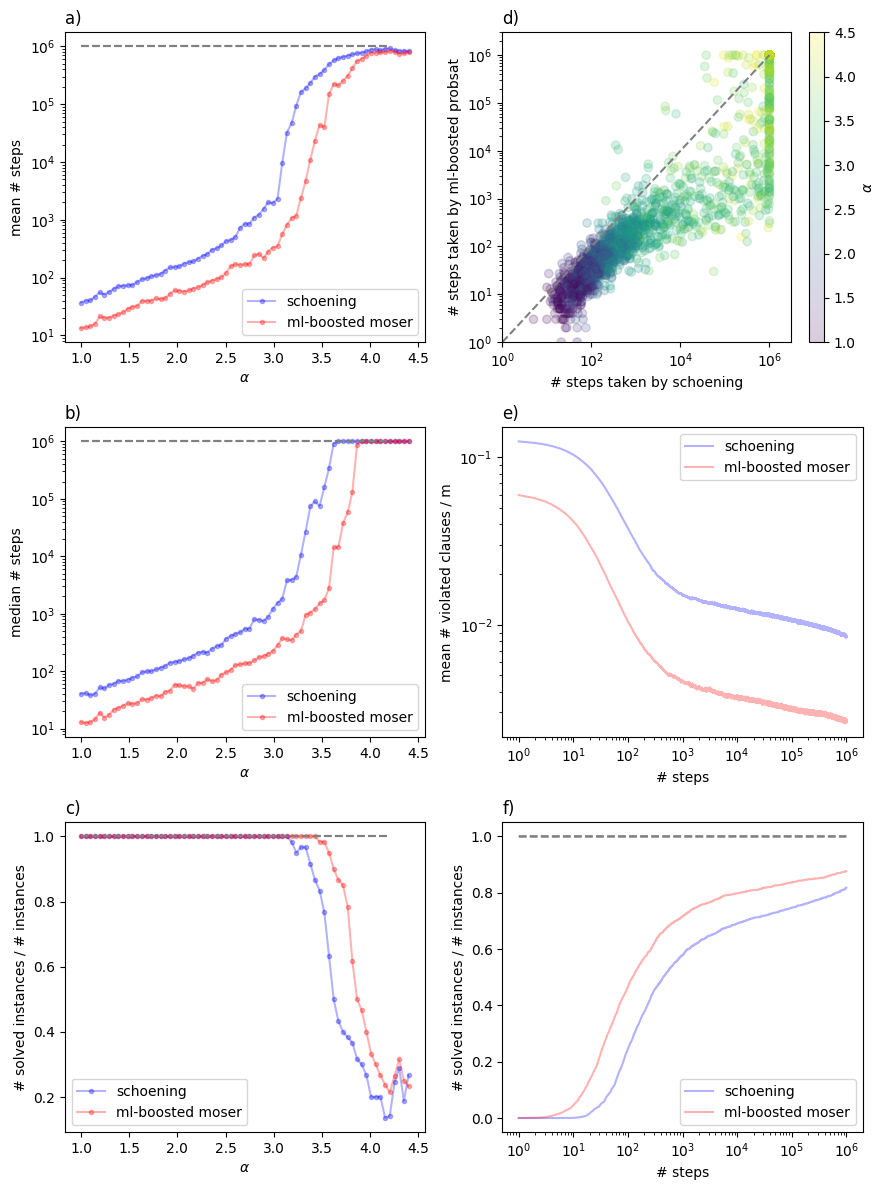

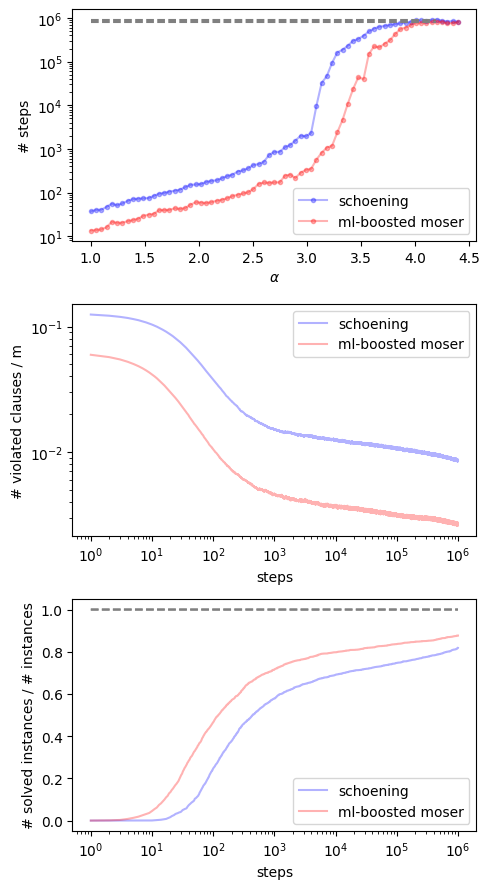

In [2]:

saved_eval_path_list=  [#"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/uniform_total_eval_EVALUATION.npy",
                        # "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/EVALbenchmark_LCG_VCG_3SAT20230601-101328.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/samples_random_3SAT_evaluation_vary_zeroschoening2.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/benchmark_LCG_VCG_3SAT20230601-101328version_probsat4.npy",

                        ]
color = ["blue", "red", "orange", "green"]
#x = np.linspace(1, 4.4, 71)
x = np.linspace(1, 4.4, 71)
x_vary = 0.05
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set2_probsat"
# do_evaluation_multiple_models(saved_eval_path_list)
do_evaluation_multiple_models_paper2probsat(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set2_probsat2"
do_evaluation_multiple_models_paper(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)
#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        # benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha") 

#benchmark_two_models(saved_eval_path_list[3], saved_eval_path_list[4], color_coded = "alpha") 

/var/folders/_5/jp84zrhn28sg9yqq0sq0dkfr0000gp/T/ipykernel_31569/778544759.py:197: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


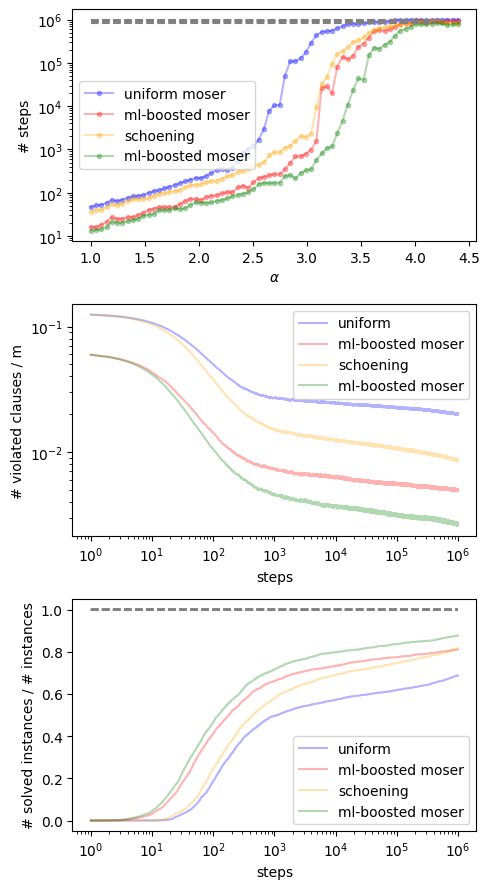

In [3]:

saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/uniform_total_eval_EVALUATION.npy",
                         "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/EVALbenchmark_LCG_VCG_3SAT20230601-101328.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/samples_random_3SAT_evaluation_vary_zeroschoening2.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/benchmark_LCG_VCG_3SAT20230601-101328version_probsat4.npy",

                        ]
color = ["blue", "red", "orange", "green"]
#x = np.linspace(1, 4.4, 71)
x = np.linspace(1, 4.4, 71)
x_vary = 0.05
#plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set2_total"
# do_evaluation_multiple_models(saved_eval_path_list)
#do_evaluation_multiple_models_paper2probsat(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set2_total2"
do_evaluation_multiple_models_paper(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)
#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        # benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha") 

#benchmark_two_models(saved_eval_path_list[3], saved_eval_path_list[4], color_coded = "alpha") 

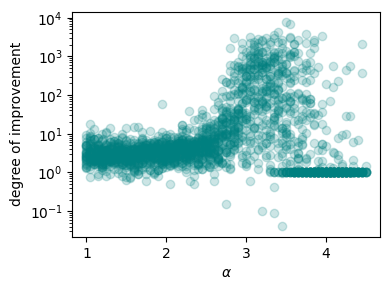

In [63]:
saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/uniform_total_eval_EVALUATION.npy",
                        #"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/schoening_total_eval_EVALUATION.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/samples_random_3SAT_evaluation_vary_zeroschoening2.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/EVALbenchmark_LCG_VCG_3SAT20230601-101328.npy",
                        ]
color = ["blue", "red", "orange"]
#x = np.linspace(1, 4.4, 71)
x = np.linspace(1, 4.4, 71)
x_vary = 0.05
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model_new_evaluation_set_DOI"
# do_evaluation_multiple_models(saved_eval_path_list)
do_evaluation_multiple_models_DOI(saved_eval_path_list, color, average_alpha = (x,x_vary), plot_save = plot_save)

#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        # benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha") 

#benchmark_two_models(saved_eval_path_list[3], saved_eval_path_list[4], color_coded = "alpha") 

2.0
3000


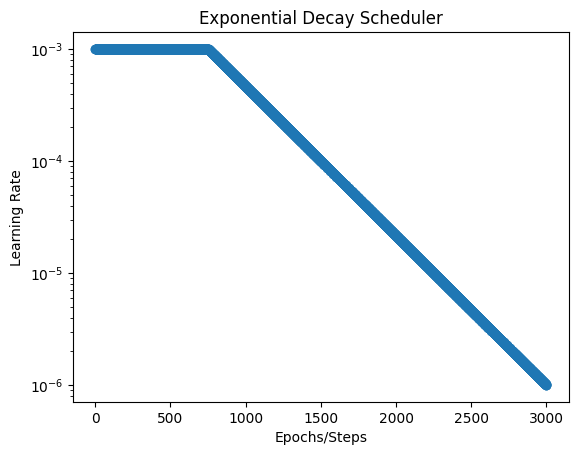

In [37]:
import matplotlib.pyplot as plt
import optax
epochs = 1500
batch_size = 30
data_shape = 31
print(np.ceil(data_shape/batch_size))
total_steps = int(epochs*np.ceil(data_shape/batch_size))
print(total_steps)
exponential_decay_scheduler = optax.exponential_decay(init_value=0.001, transition_steps=total_steps,
                                                      decay_rate=0.0001, transition_begin=int(total_steps*0.25),
                                                      staircase=False)

lrs = [exponential_decay_scheduler(i) for i in range(total_steps)]

plt.scatter(range(total_steps), lrs)
plt.title("Exponential Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")
plt.yscale("log")

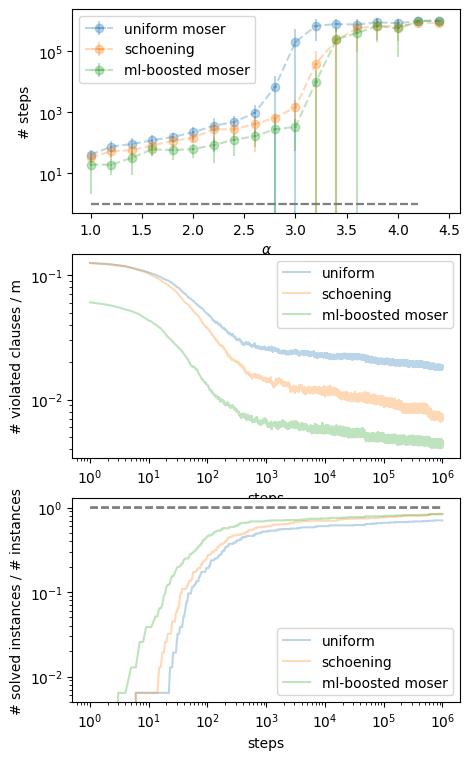

IndexError: list index out of range

In [28]:
#saved_eval_path_list = ["/Users/p403830/Downloads/samples_random_3SAT/uniform_total_eval_EVALUATION_SET.npy",
#                        "/Users/p403830/Downloads/samples_random_3SAT/schoening_total_eval_EVALUATION.npy",
saved_eval_path_list=  ["/Users/p403830/Downloads/samples_random_3SAT/uniform.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/schoening2.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-095324.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230602-011857.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-084252.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-101328.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-101328.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-132014.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-162001.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-172452.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-182806.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-184357.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-223200.npy",
                        ]

x = np.linspace(1, 4.4, 18)
x_vary = 0.05
plot_save = "/Users/p403830/Downloads/samples_random_3SAT/plot_best_model"
do_evaluation_multiple_models_paper(saved_eval_path_list, average_alpha = (x,x_vary), plot_save = plot_save)

#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        # benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha") 

benchmark_two_models(saved_eval_path_list[3], saved_eval_path_list[4], color_coded = "alpha") 

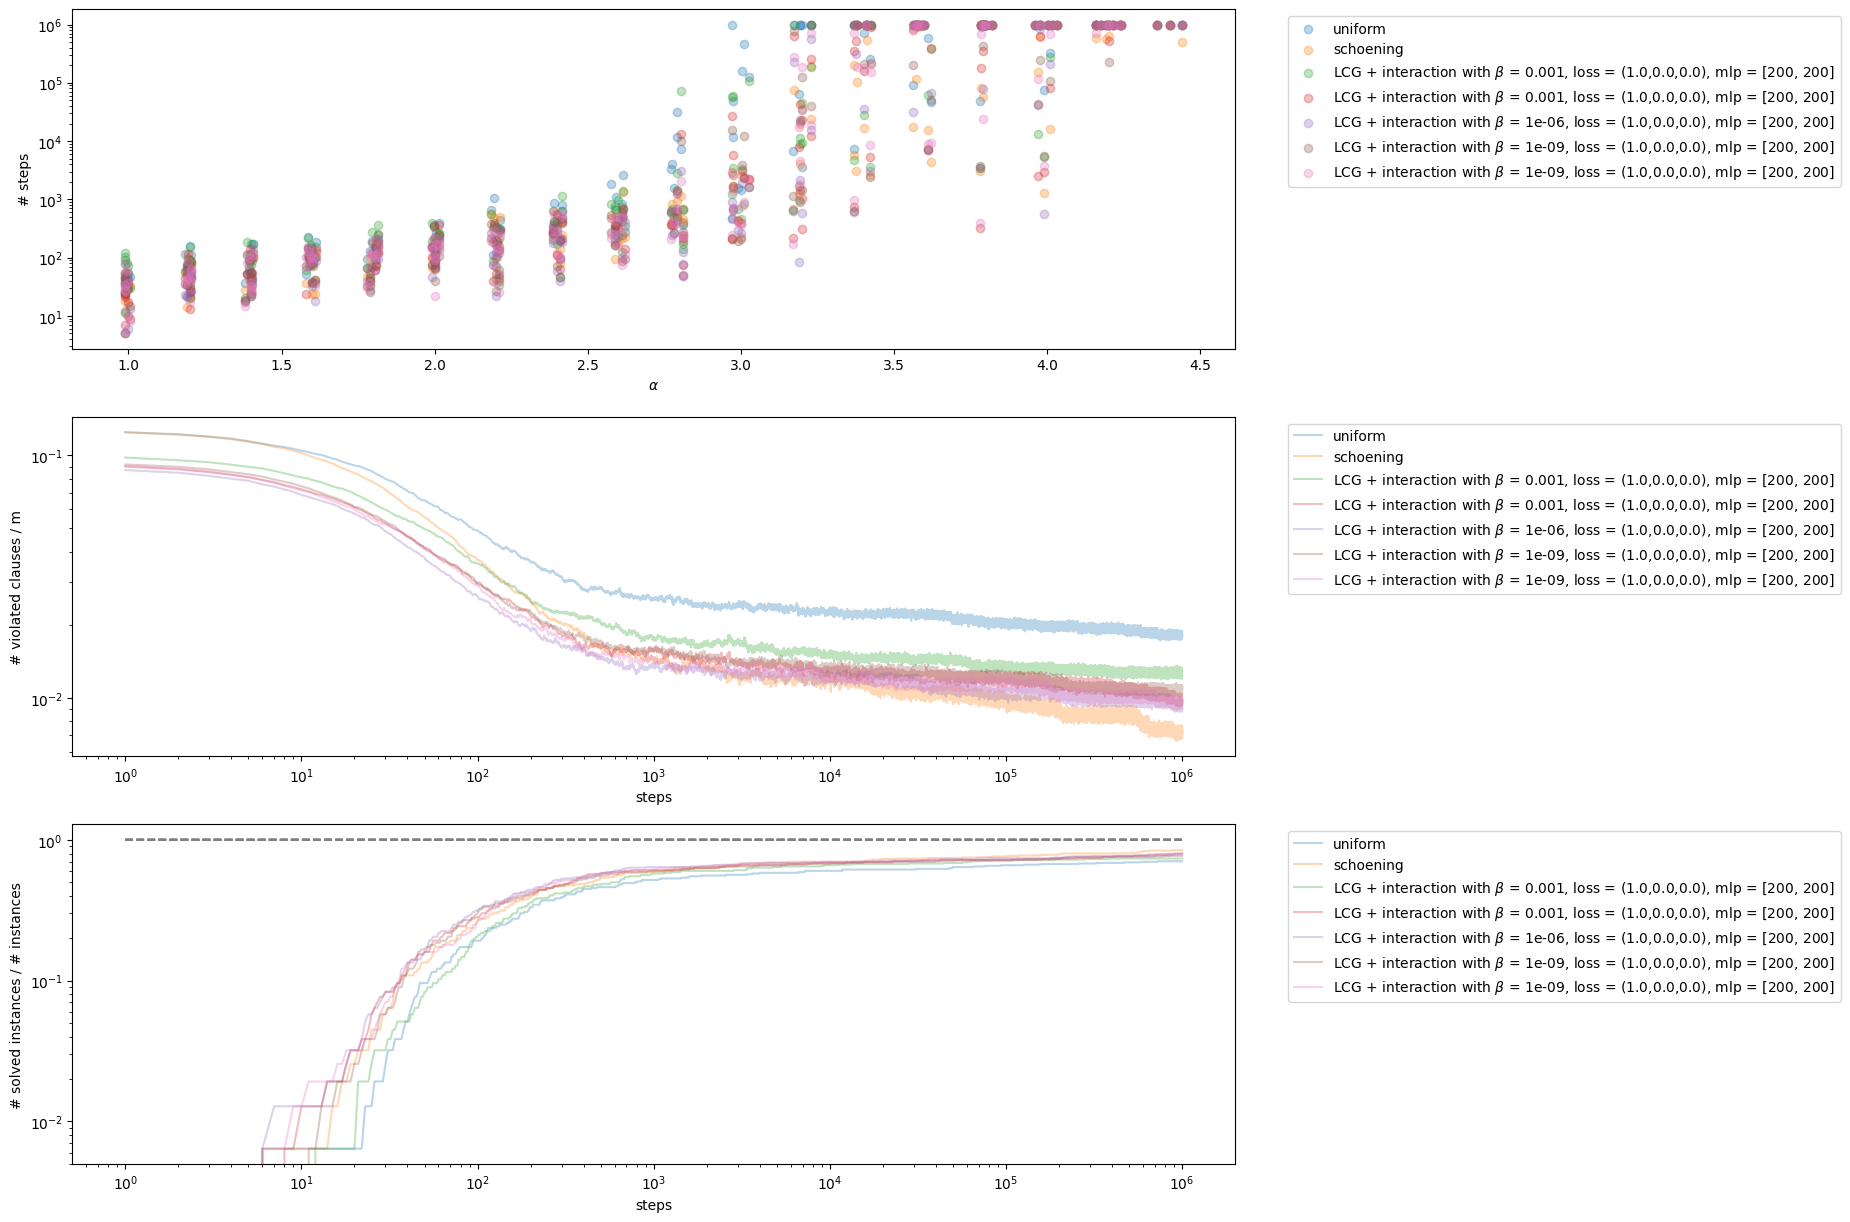

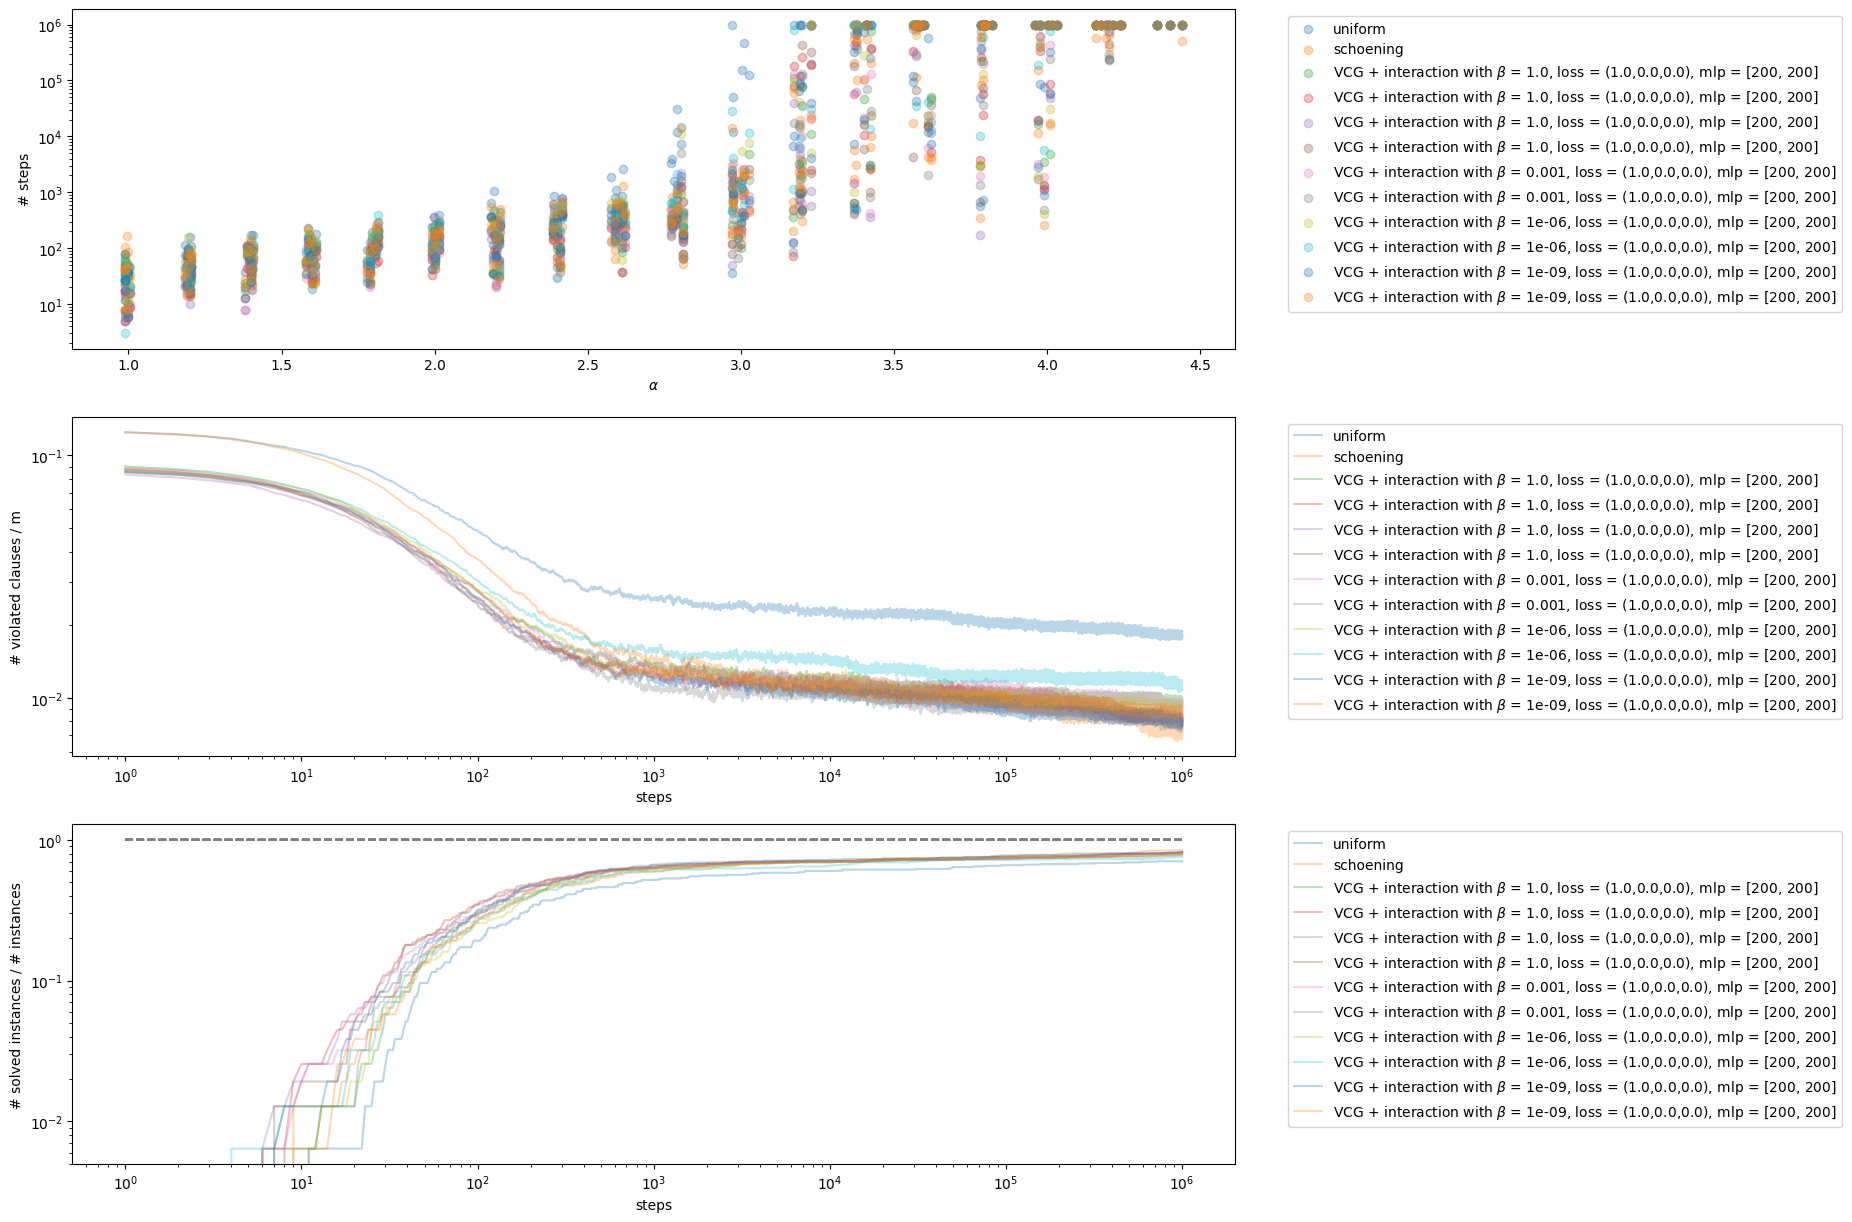

IndexError: list index out of range

In [69]:
#saved_eval_path_list = ["/Users/p403830/Downloads/samples_random_3SAT/uniform_total_eval_EVALUATION_SET.npy",
#                        "/Users/p403830/Downloads/samples_random_3SAT/schoening_total_eval_EVALUATION.npy",]
saved_eval_path_list_vcg= [ "/Users/p403830/Downloads/samples_random_3SAT/uniform.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/schoening2.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_VCG_right_inv_temp_3SAT20230602-124730.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230602-100847.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230602-150818.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_VCG_right_inv_temp_3SAT20230602-173237.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_VCG_right_inv_temp_3SAT20230602-132025.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_VCG_right_inv_temp_3SAT20230602-180530.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_VCG_right_inv_temp_3SAT20230602-183853.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_VCG_right_inv_temp_3SAT20230602-135619.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_VCG_right_inv_temp_3SAT20230602-143137.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_VCG_right_inv_temp_3SAT20230602-191143.npy",
                            ]
saved_eval_path_list_lcg= ["/Users/p403830/Downloads/samples_random_3SAT/uniform.npy",
                           "/Users/p403830/Downloads/samples_random_3SAT/schoening2.npy",
                           "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230602-104443.npy",
                           "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230602-154219.npy",
                           "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230602-161849.npy",
                           "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230602-120608.npy",
                           "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230602-165542.npy",
                        ]
do_evaluation_multiple_models(saved_eval_path_list_lcg)
do_evaluation_multiple_models(saved_eval_path_list_vcg)
#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        # benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha") 

benchmark_two_models(saved_eval_path_list[1], saved_eval_path_list[6], color_coded = "alpha") 

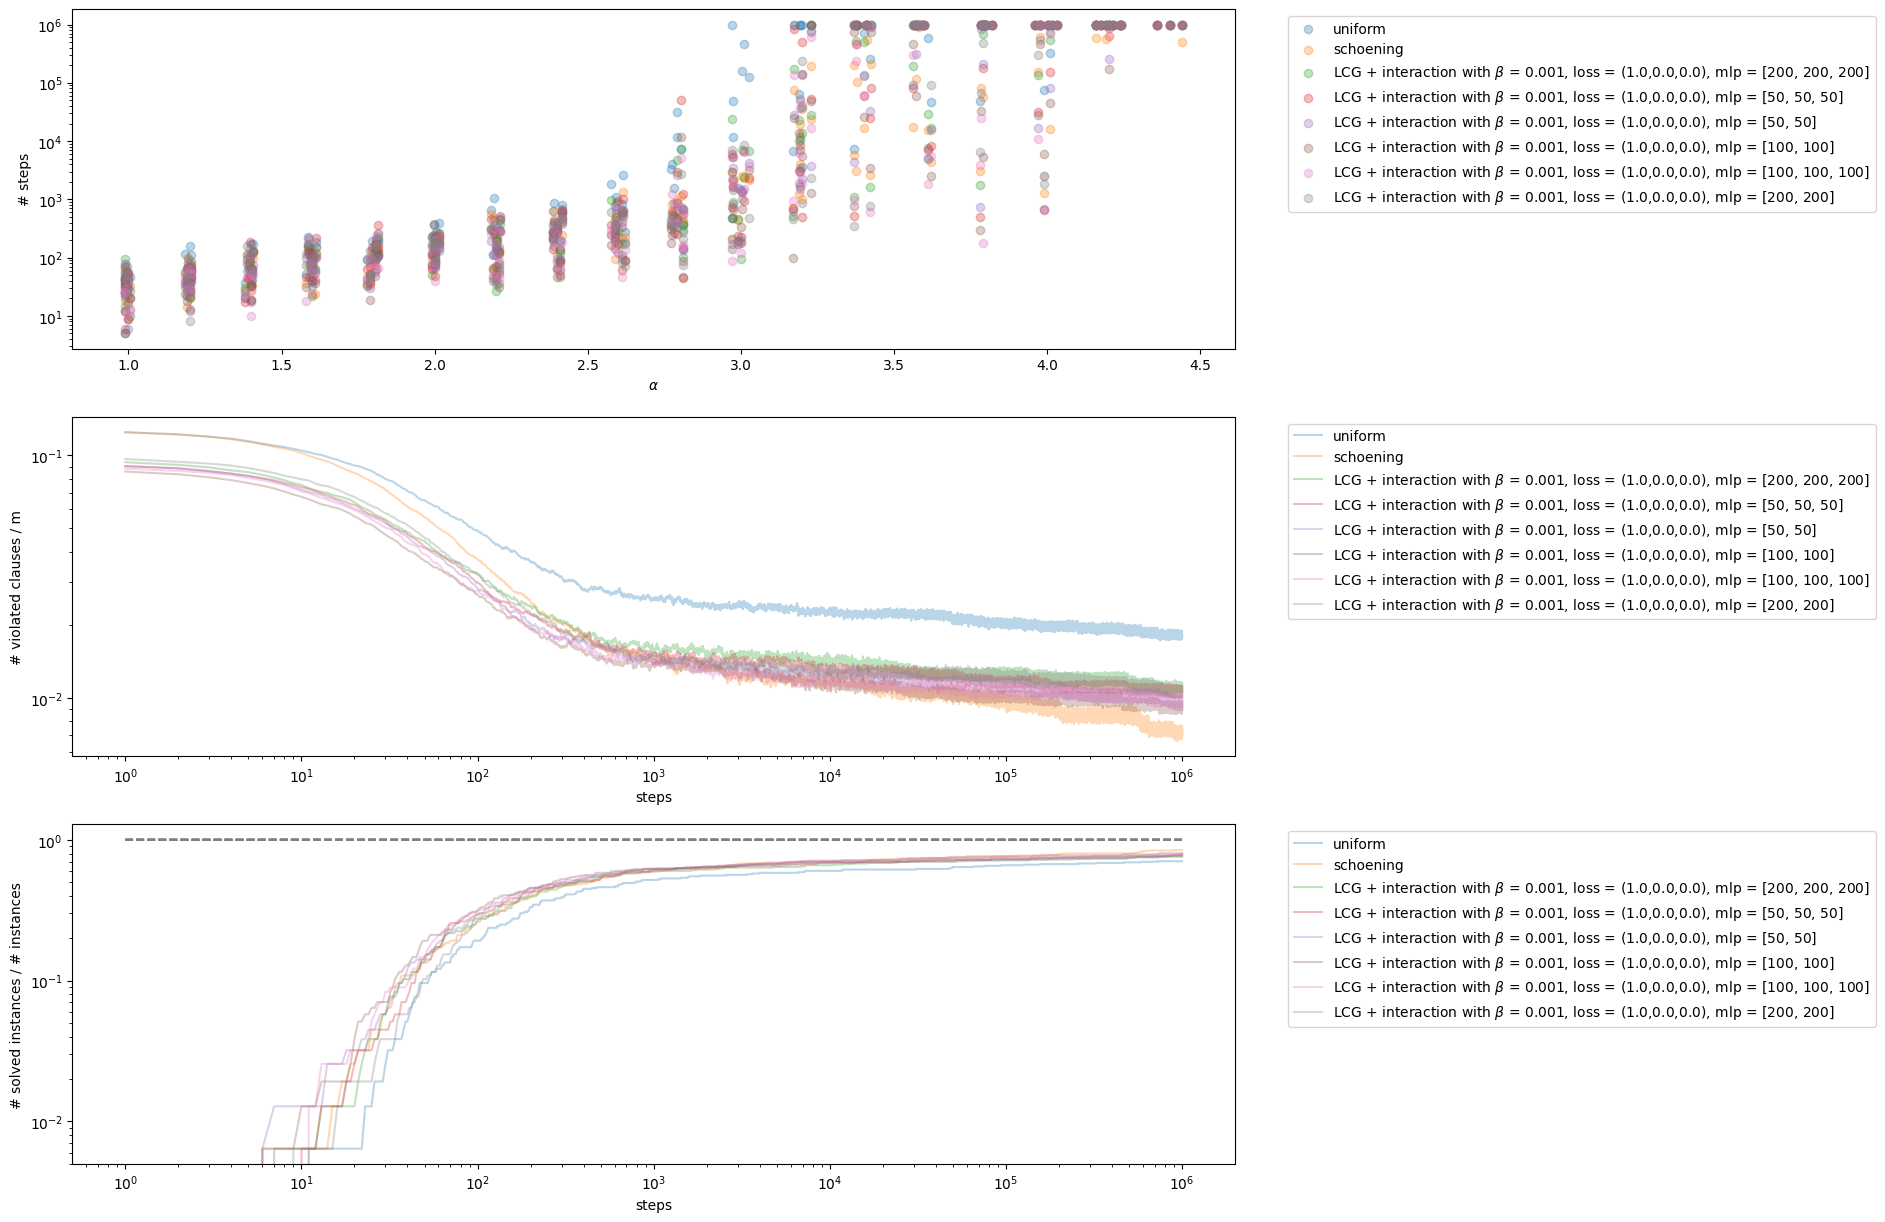

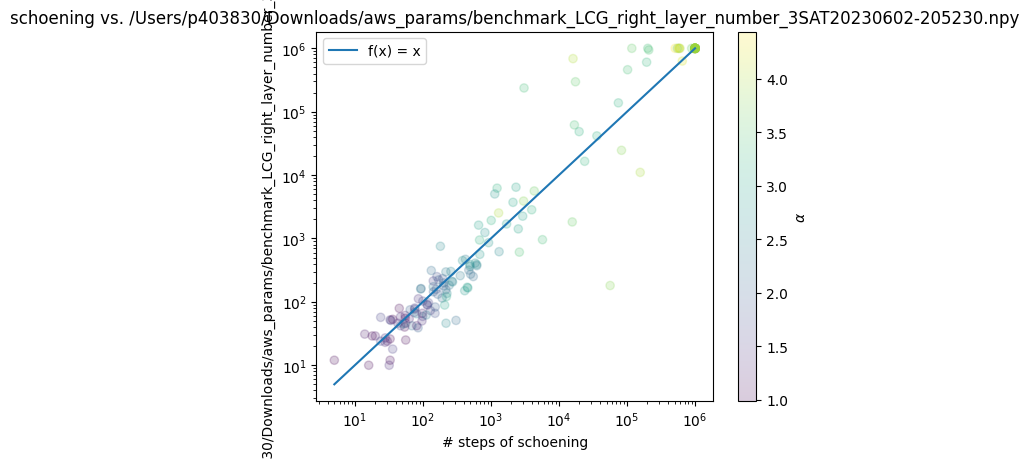

In [70]:
#saved_eval_path_list = ["/Users/p403830/Downloads/samples_random_3SAT/uniform_total_eval_EVALUATION_SET.npy",
#                        "/Users/p403830/Downloads/samples_random_3SAT/schoening_total_eval_EVALUATION.npy",
saved_eval_path_list= [ "/Users/p403830/Downloads/samples_random_3SAT/uniform.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/schoening2.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-220634.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-232048.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-224400.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-201511.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-205230.npy",
                            "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-212959.npy",

                            ]
#saved_eval_path_list_lcg= ["/Users/p403830/Downloads/samples_random_3SAT/uniform.npy",
#                           "/Users/p403830/Downloads/samples_random_3SAT/schoening2.npy",
#                           "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230602-104443.npy",
#                          "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230602-154219.npy",
#                          "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230602-161849.npy",
#                          "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230602-120608.npy",
#                           "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_inv_temp_3SAT20230602-165542.npy",
#                        ]
do_evaluation_multiple_models(saved_eval_path_list)
#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        # benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha") 

#benchmark_two_models(saved_eval_path_list[1], saved_eval_path_list[6], color_coded = "alpha") 

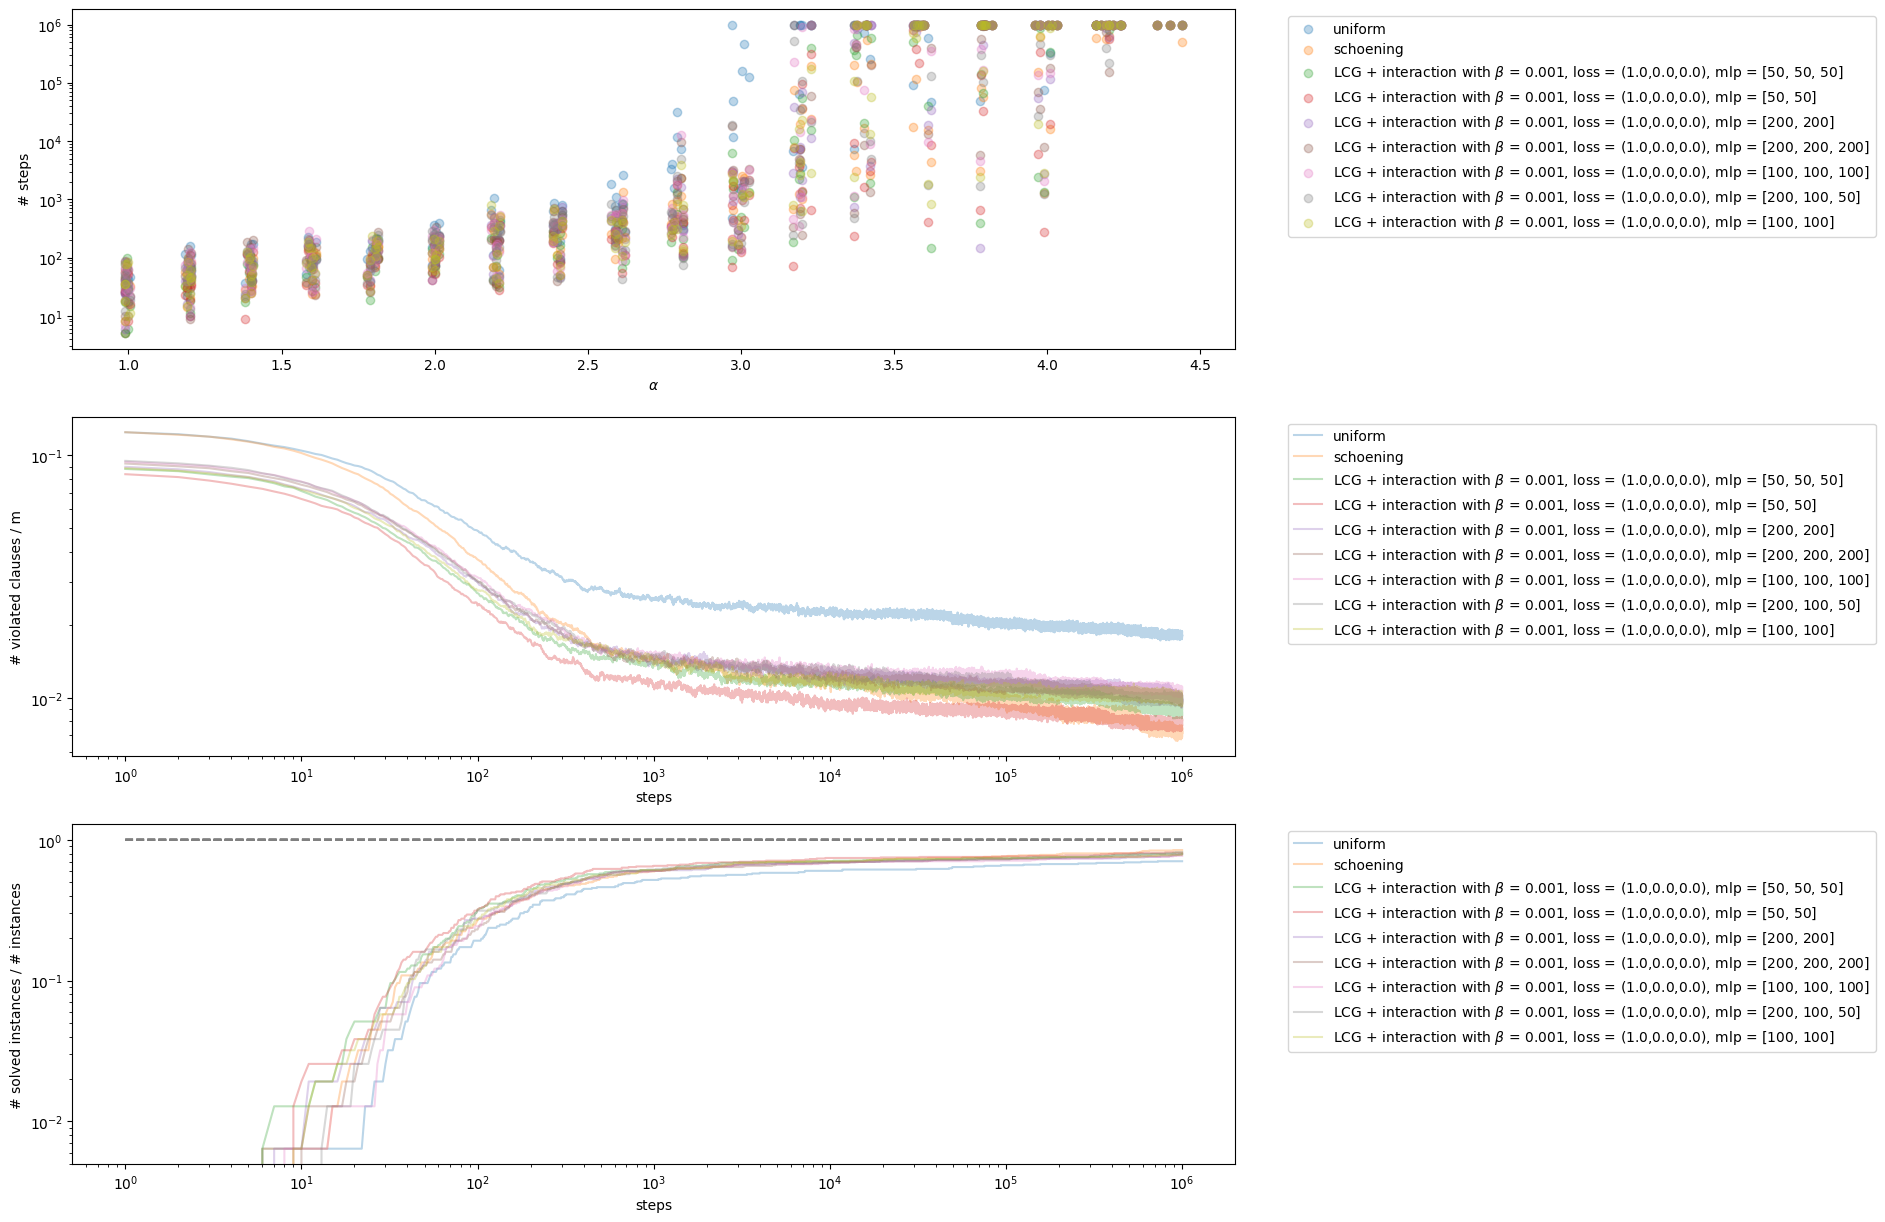

In [71]:
#saved_eval_path_list = ["/Users/p403830/Downloads/samples_random_3SAT/uniform_total_eval_EVALUATION_SET.npy",
#                        "/Users/p403830/Downloads/samples_random_3SAT/schoening_total_eval_EVALUATION.npy",
saved_eval_path_list=  ["/Users/p403830/Downloads/samples_random_3SAT/uniform.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/schoening2.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-232048.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-234205.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-230617.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-222541.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-214708.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-211008.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-203344.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-192144.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-195841.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-104453.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-184532.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-180437.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-172423.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-160236.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-164314.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-142839.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-150943.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-134828.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-112525.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-124638.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-100350.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-120634.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-092330.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-201511.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-205230.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-212959.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-224400.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-220634.npy",
                        ]
do_evaluation_multiple_models(saved_eval_path_list)

#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        # benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha") 

#benchmark_two_models(saved_eval_path_list[3], saved_eval_path_list[4], color_coded = "alpha") 


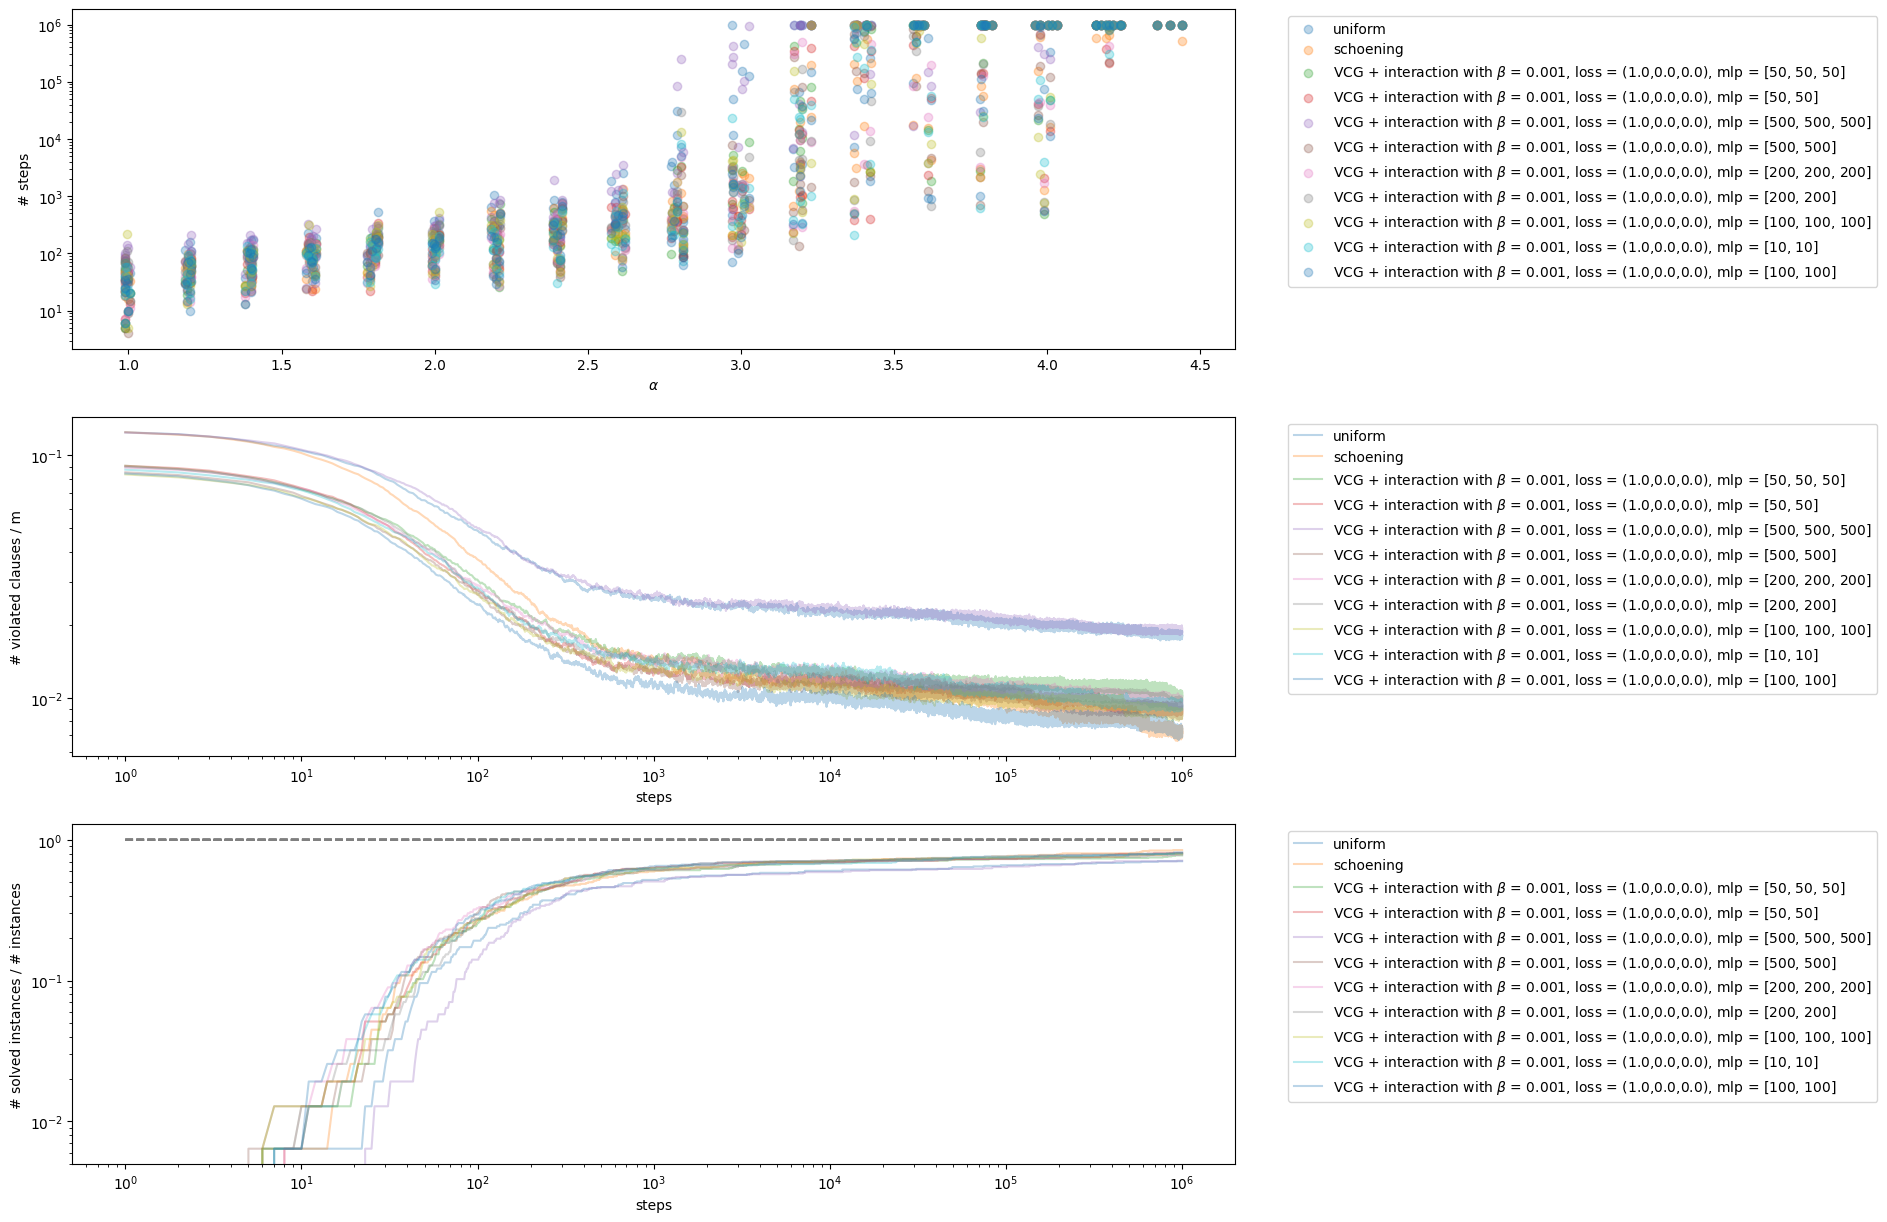

In [72]:
#saved_eval_path_list = ["/Users/p403830/Downloads/samples_random_3SAT/uniform_total_eval_EVALUATION_SET.npy",
#                        "/Users/p403830/Downloads/samples_random_3SAT/schoening_total_eval_EVALUATION.npy",
saved_eval_path_list=  ["/Users/p403830/Downloads/samples_random_3SAT/uniform.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/schoening2.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-232048.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-234205.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-230617.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-222541.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-214708.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-211008.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-203344.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-192144.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-195841.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-104453.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-184532.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-180437.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-172423.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-160236.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-164314.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-142839.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-150943.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-134828.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-112525.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-124638.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-100350.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-120634.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230603-092330.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-201511.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-205230.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-212959.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-224400.npy",
                        #"/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT20230602-220634.npy",
                        ]
do_evaluation_multiple_models(saved_eval_path_list)

#for saved_eval_path in saved_eval_path_list:
#    do_evaluation_for_single_model(saved_eval_path)

#for i in range(len(saved_eval_path_list)):
#    for j in range(i):
#        print(i,j)
#        # benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "n")
#        benchmark_two_models(saved_eval_path_list[i], saved_eval_path_list[j], color_coded = "alpha") 

#benchmark_two_models(saved_eval_path_list[3], saved_eval_path_list[4], color_coded = "alpha") 


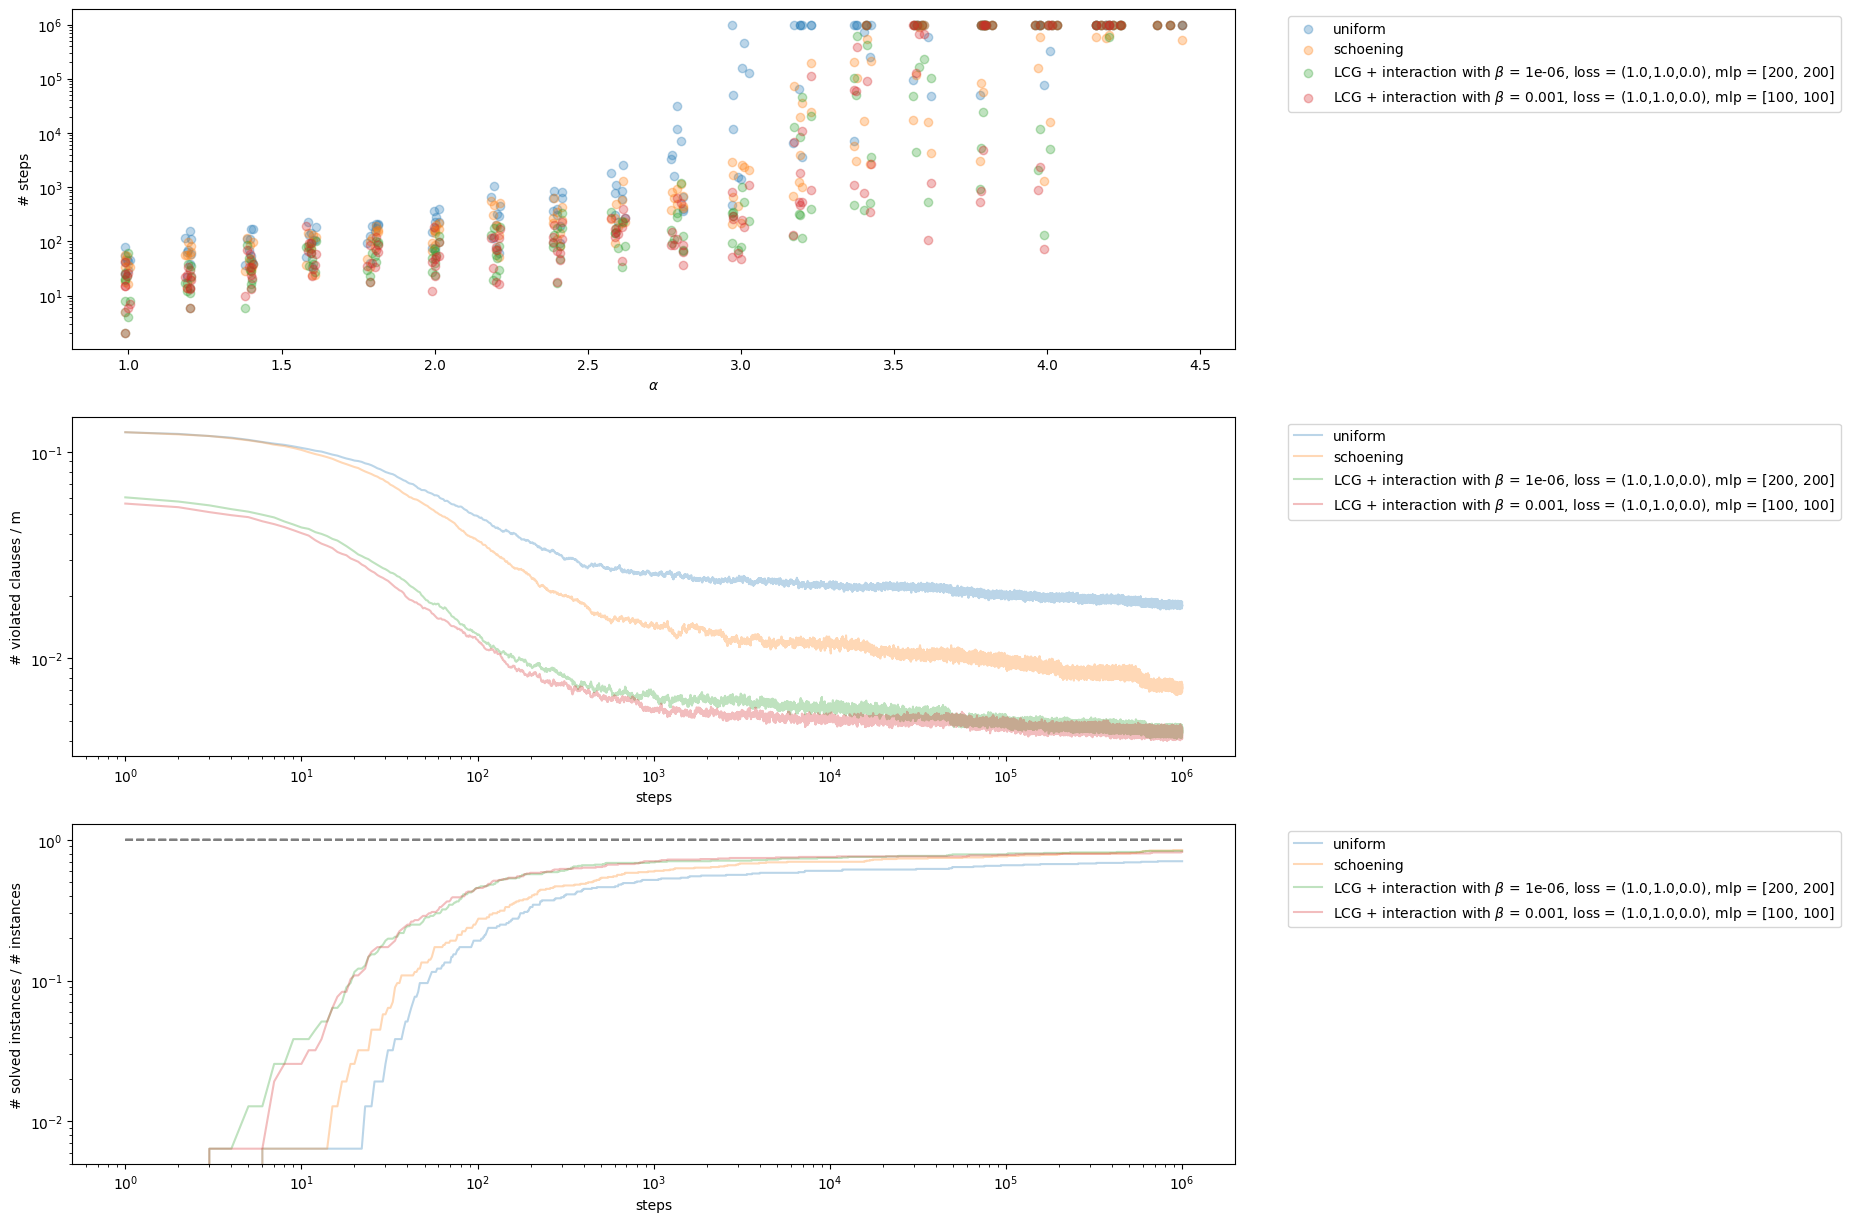

In [75]:


#saved_eval_path_list = ["/Users/p403830/Downloads/samples_random_3SAT/uniform_total_eval_EVALUATION_SET.npy",
#                        "/Users/p403830/Downloads/samples_random_3SAT/schoening_total_eval_EVALUATION.npy",
saved_eval_path_list=  ["/Users/p403830/Downloads/samples_random_3SAT/uniform.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/schoening2.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_VCG_3SAT20230601-101328.npy",
                        "/Users/p403830/Downloads/samples_random_3SAT/benchmark_LCG_right_layer_number_3SAT_LLL20230604-103604.npy",
                        ]
do_evaluation_multiple_models(saved_eval_path_list)

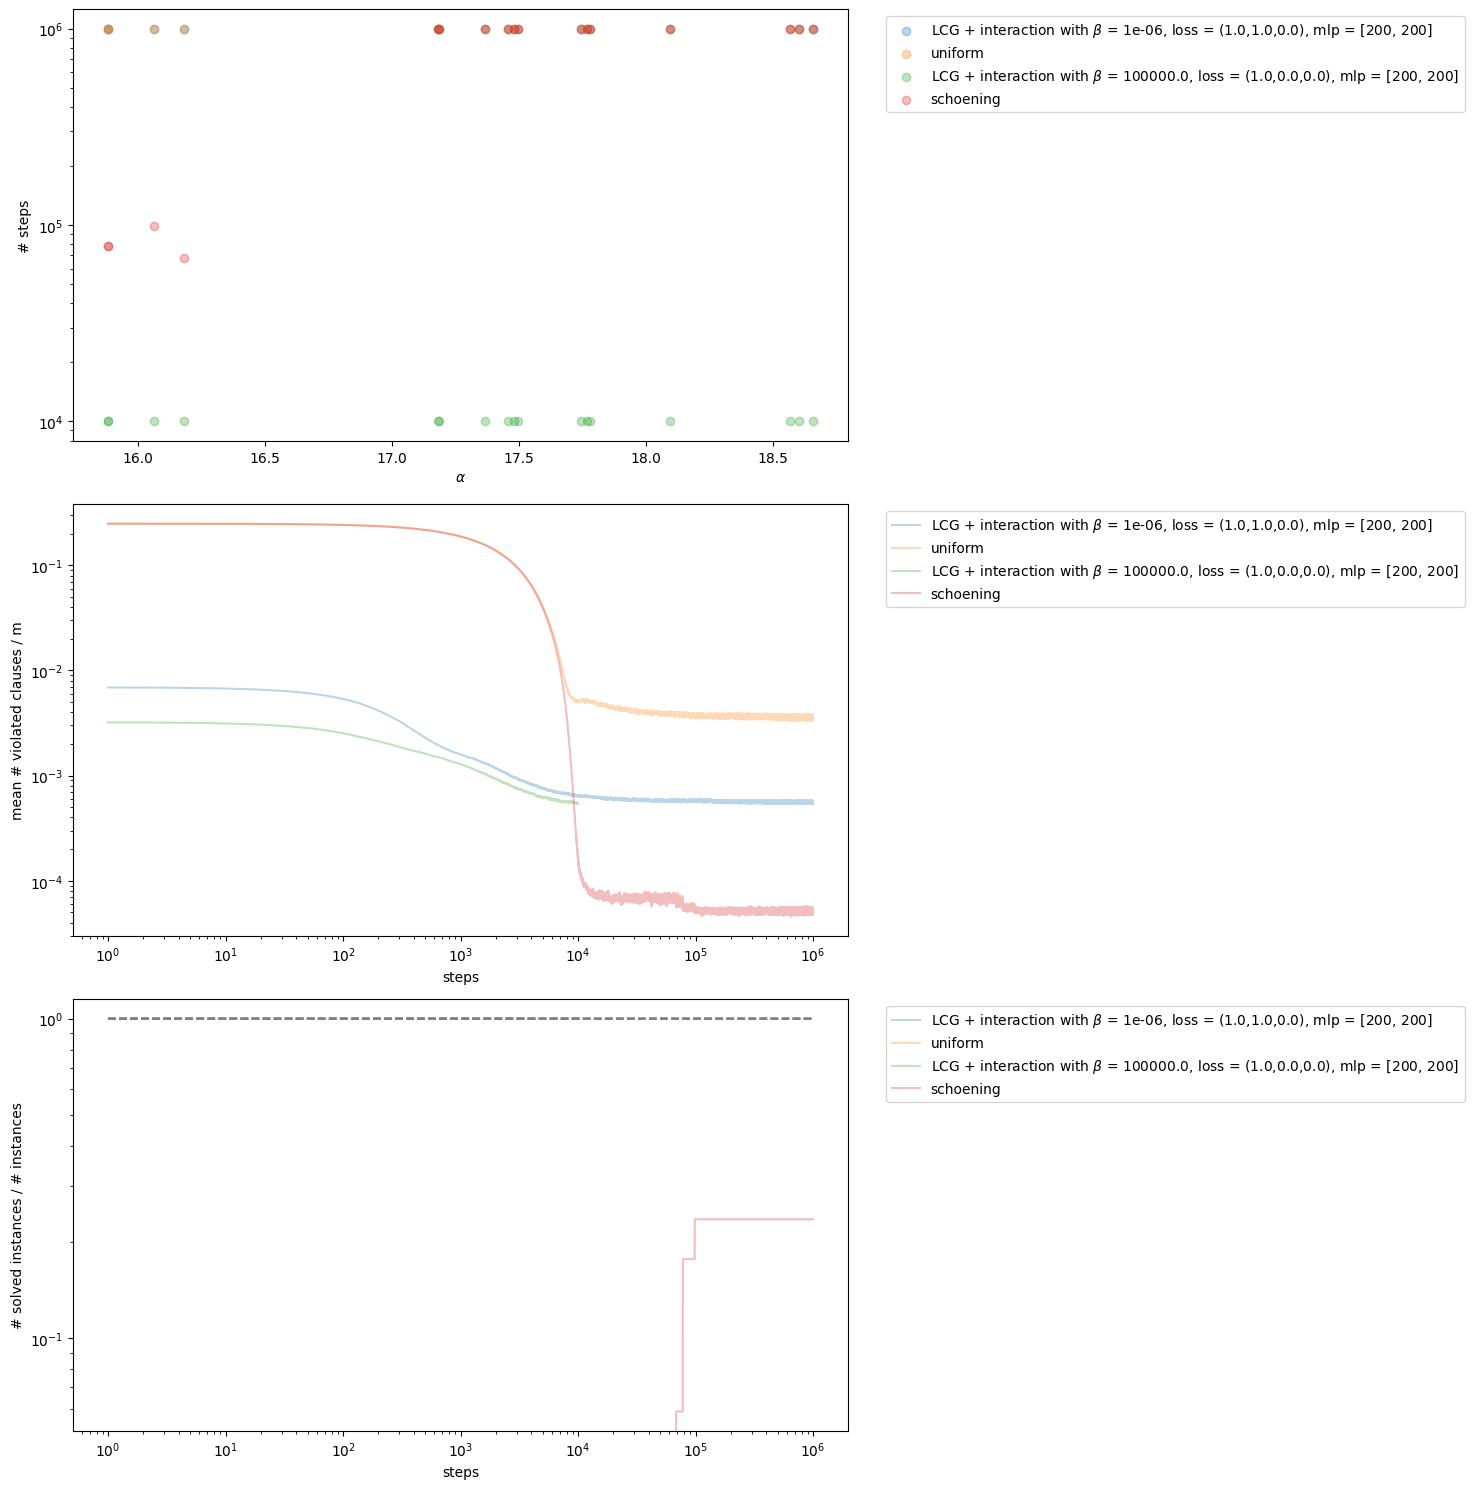

In [5]:

saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/ml_based_sat_solver/BroadcastTestSet_subset/evalbenchmark_LCG_VCG_3SAT20230601-101328_new.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/ml_based_sat_solver/BroadcastTestSet_subset/evaluniform.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/ml_based_sat_solver/BroadcastTestSet_subset/one_sample20230712-211058version3.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/ml_based_sat_solver/BroadcastTestSet_subset/eval_schoening_NEW2.npy"
                        ]
do_evaluation_multiple_models(saved_eval_path_list)

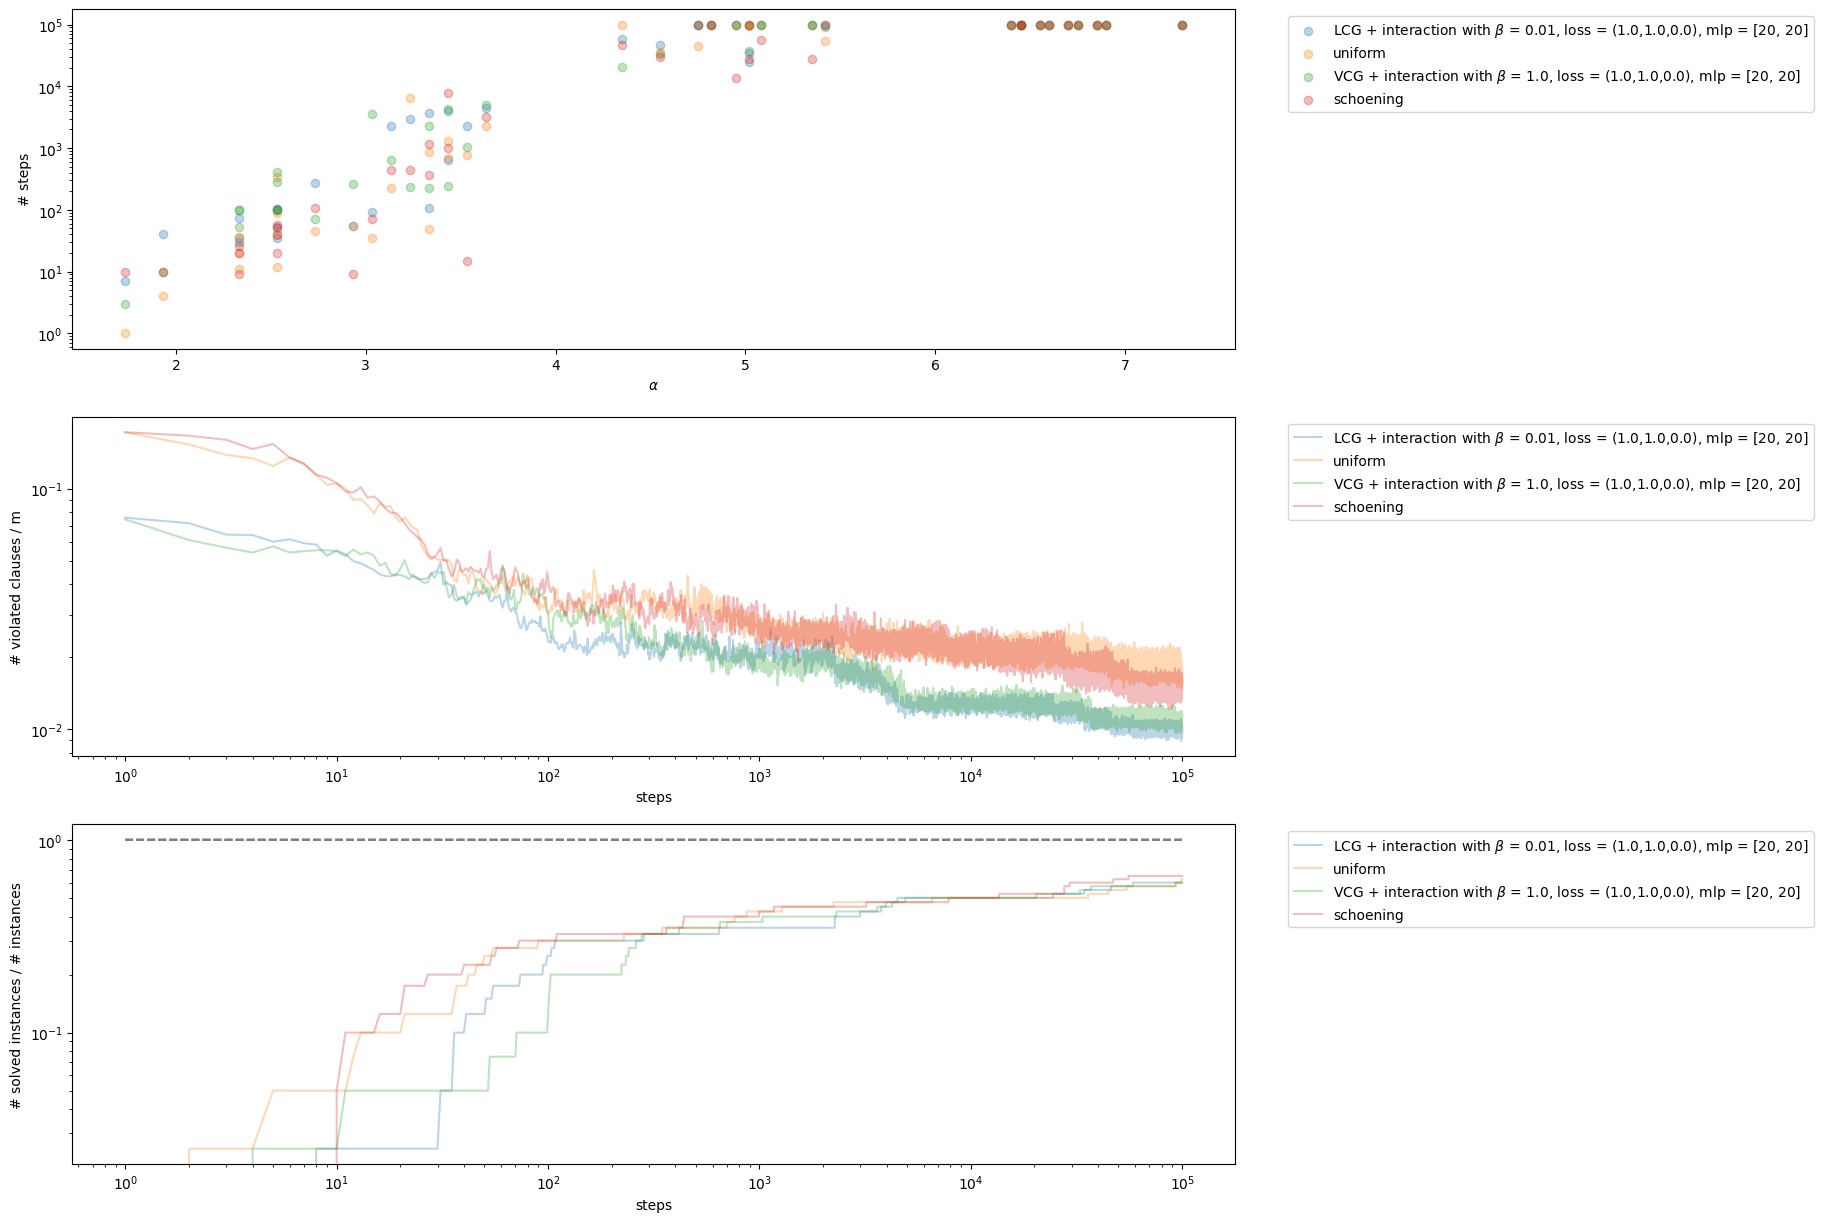

In [12]:
saved_eval_path_list=  ["/Users/p403830/Downloads/kcolor_subsetEVAL_wholekcolor20230627-161920.npy",
                        "/Users/p403830/Downloads/kcolor_subsetEVAL_wholeuniform.npy",
                        "/Users/p403830/Downloads/kcolor_subset/EVAL_wholekcolor20230627-230755.npy",
                        #"/Users/p403830/Downloads/kcolor_subset/EVAL_wholekcolor20230627-163443.npy",
                        #"/Users/p403830/Downloads/kcolor_subset/EVAL_wholekcolor20230627-163443.npy",
                        #"/Users/p403830/Downloads/kcolor_subset/EVAL_wholekcolor20230627-170230.npy",
                        #"/Users/p403830/Downloads/kcolor_subset/EVAL_wholekcolor20230627-164027.npy",
                        "/Users/p403830/Downloads/kcolor_subset/EVAL_wholeschoening.npy"
                        ]
do_evaluation_multiple_models(saved_eval_path_list)

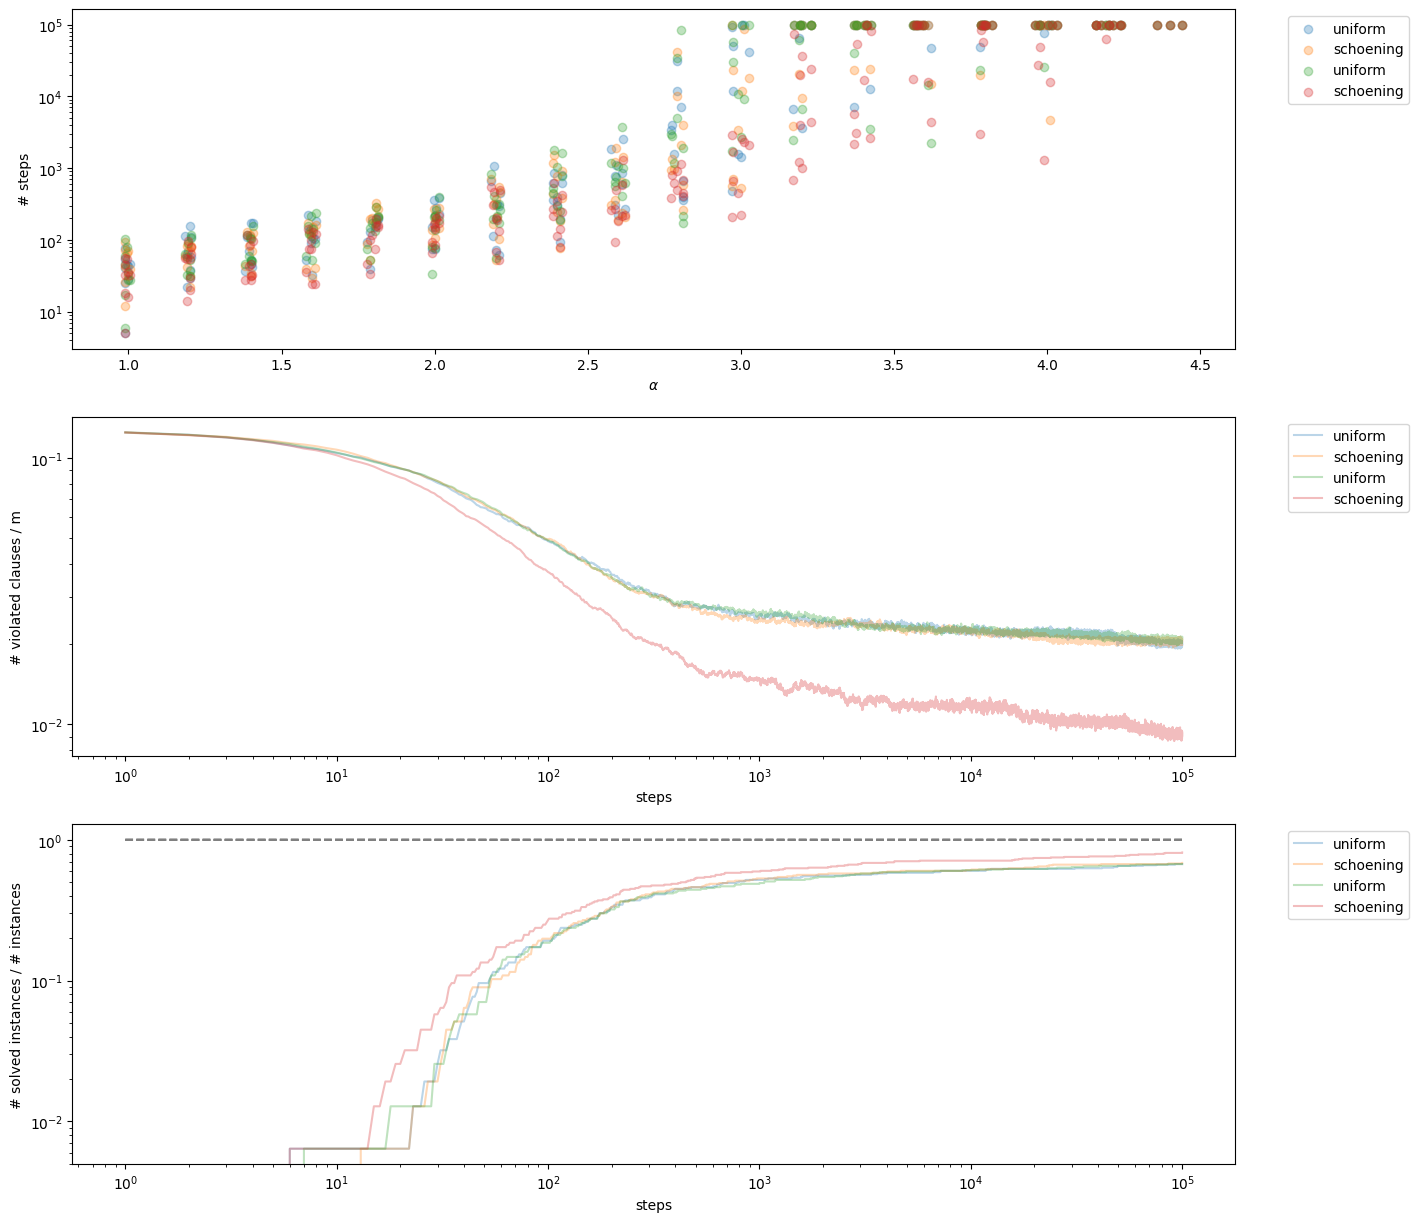

In [15]:
saved_eval_path_list=  ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/uniformEVAL_NEW___.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/schoeningEVAL_NEW___.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/uniformEVAL_NEW___2.npy",
                        "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/schoeningEVAL_NEW___2.npy",
                        ]
do_evaluation_multiple_models(saved_eval_path_list)

IndexError: list index out of range

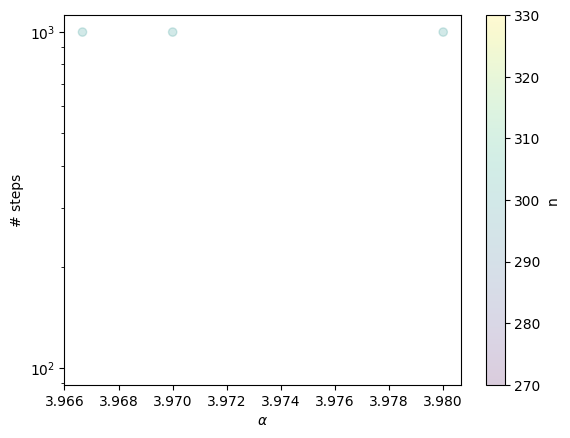

In [ ]:
plot_number_of_steps_single_model(total_steps, n_array, alpha_array, model_details)

In [ ]:
import plotly.express as px
# df = px.data.tips()
df = {"alpha": alpha_array, "num_steps": total_steps, "n": n_array}
fig = px.scatter(df, x="alpha", y="num_steps", color="n",
                 title="numsteps of moser as a function of alpha")

fig.show()

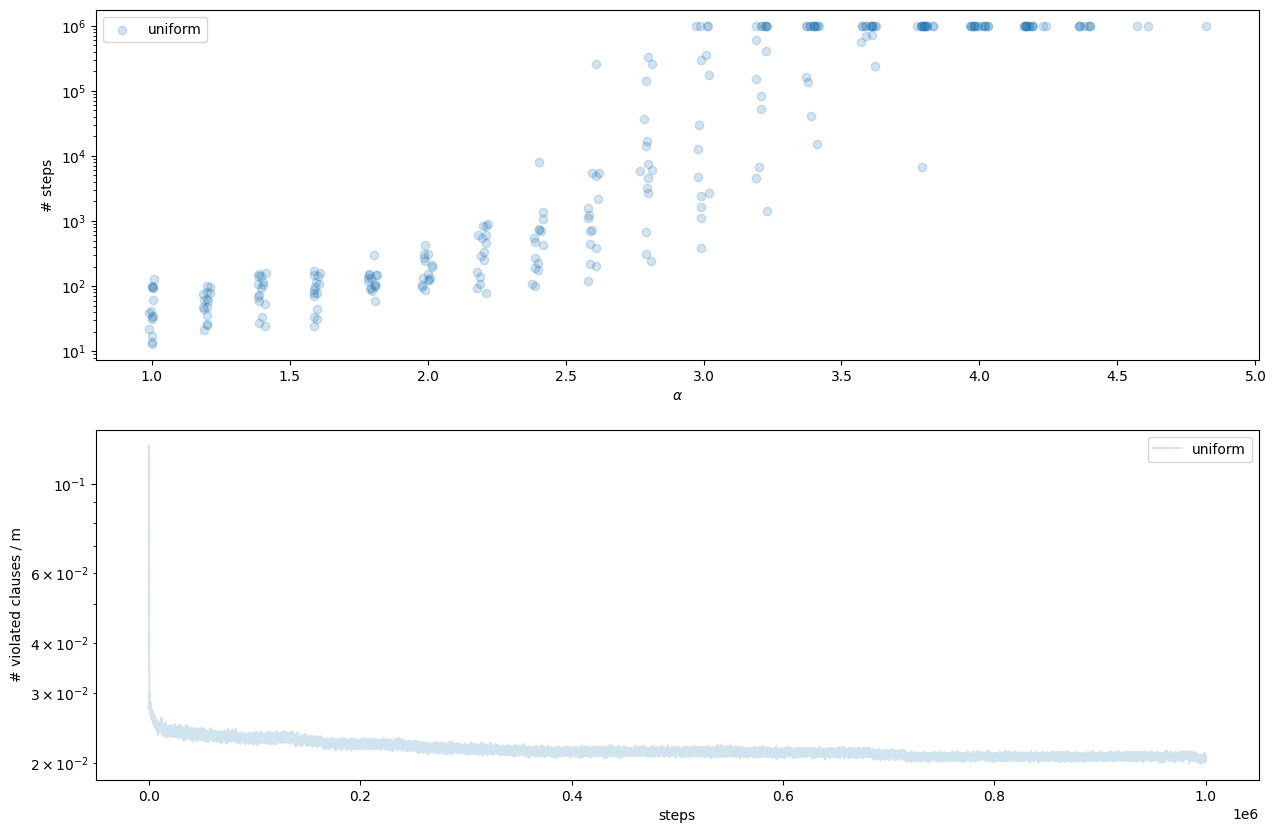

In [ ]:
saved_eval_path_list = ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT/uniform_total_eval.npy"]
do_evaluation_multiple_models(saved_eval_path_list)

for saved_eval_path in saved_eval_path_list:
    do_evaluation_for_single_model(saved_eval_path)

In [ ]:
total_steps = [2,3,3,1]
counter_array = []
for i in range(4):
    x = np.sum(np.where(total_steps<=i*np.ones(len(total_steps)), 1, 0))
    print(x)
    counter_array.append(x/len(total_steps))
    print(counter_array)

0
[0.0]
1
[0.0, 0.25]
2
[0.0, 0.25, 0.5]
4
[0.0, 0.25, 0.5, 1.0]


In [2]:
import moser_rust
import numpy as np
from pysat.formula import CNF

problem_path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML/data/BroadcastTestSet_subset/41-20486.cnf"

problem = CNF(from_file=problem_path)
n = problem.nv
N_STEPS_MOSER = 1000000
N_RUNS_MOSER = 5
SEED = 0
_, _, final_energies, numtry, numstep, traj = moser_rust.run_sls_python(
                "moser",
                problem_path,
                np.ones(n)/2,
                N_STEPS_MOSER - 1,
                N_RUNS_MOSER,
                SEED,
                True,
            )

In [3]:
print(final_energies)

144


In [21]:
from evaluate_with_given_params import load_model_and_test_moser_single
data_path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/uf20_subset/"

model_paths = ["uniform", 
               "schoening",
               "/Users/p403830/Downloads/aws_params/benchmark_LCG_VCG_3SAT20230601-101328.npy"]

N_STEPS_MOSER = 1000000
N_RUNS_MOSER = 5
for model_path in model_paths:
    path_save = data_path + "eval" +model_path.split("/")[-1]
    print(path_save)
    print("model_path", model_path)
    total_array2 = load_model_and_test_moser_single(
        data_path, model_path, N_STEPS_MOSER, N_RUNS_MOSER, path_save = path_save
    )

/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/uf20_subset/evaluniform
model_path uniform
problem  1 of  1
/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/uf20_subset/evalschoening
model_path schoening
problem  1 of  1
/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/uf20_subset/evalbenchmark_LCG_VCG_3SAT20230601-101328.npy
model_path /Users/p403830/Downloads/aws_params/benchmark_LCG_VCG_3SAT20230601-101328.npy
LCG
problem  1 of  1


In [9]:

from evaluate_with_given_params import load_model_and_test_moser_single

data_path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/"
#model_paths = ["/Users/p403830/Downloads/aws_params/benchmark_LCG_VCG_3SAT20230530-122213.npy",
#               "/Users/p403830/Downloads/aws_params/benchmark_LCG_VCG_3SAT20230530-155713.npy",]
#model_paths = ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML3/ml_based_sat_solver/experiments/params_save/benchmark_LCG_right_inv_temp_3SAT20230530-214741.npy",
#               "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML3/ml_based_sat_solver/experiments/params_save/benchmark_LCG_right_inv_temp_3SAT20230531-032807.npy"]
model_paths = [#"/Users/p403830/Downloads/aws_params/benchmark_LCG_right_layer_number_3SAT20230602-232048.npy",
               #"/Users/p403830/Downloads/aws_params/benchmark_LCG_right_layer_number_3SAT20230602-220634.npy",
                "/Users/p403830/Downloads/aws_params/benchmark_LCG_VCG_3SAT20230608-173245.npy",
                "/Users/p403830/Downloads/aws_params/benchmark_LCG_right_layer_number_3SAT_LLL20230609-113632.npy",
                "/Users/p403830/Downloads/aws_params/benchmark_LCG_VCG_3SAT20230608-202600.npy",
                "/Users/p403830/Downloads/aws_params/benchmark_LCG_VCG_3SAT20230608-151532.npy",
               #"/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_right_layer_number_3SAT_LLL20230604-103604.npy",
               ]

#model_pacd .ths = ["/Users/p403830/Downloads/aws_params/benchmark_LCG_right_inv_temp_3SAT20230530-214741.npy",
#               "/Users/p403830/Downloads/aws_params/benchmark_LCG_right_inv_temp_3SAT20230531-032807.npy",
#               "/Users/p403830/Downloads/aws_params/benchmark_LCG_right_inv_temp_3SAT20230531-113933.npy"
#                ]
N_STEPS_MOSER = 1000000
N_RUNS_MOSER = 5
for model_path in model_paths:
    path_save = data_path + model_path.split("/")[-1]
    print(path_save)

    total_array2 = load_model_and_test_moser_single(
        data_path, model_path, N_STEPS_MOSER, N_RUNS_MOSER, path_save = path_save
    )

/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation/benchmark_LCG_VCG_3SAT20230608-173245.npy
VCG
problem  1 of  156
problem  2 of  156
problem  3 of  156
problem  4 of  156
problem  5 of  156
problem  6 of  156
problem  7 of  156
problem  8 of  156
problem  9 of  156
problem  10 of  156
problem  11 of  156
problem  12 of  156
problem  13 of  156
problem  14 of  156
problem  15 of  156
problem  16 of  156
problem  17 of  156
problem  18 of  156
problem  19 of  156
problem  20 of  156
problem  21 of  156
problem  22 of  156
problem  23 of  156
problem  24 of  156
problem  25 of  156
problem  26 of  156
problem  27 of  156
problem  28 of  156
problem  29 of  156
problem  30 of  156
problem  31 of  156
problem  32 of  156
problem  33 of  156
problem  34 of  156
problem  35 of  156
problem  36 of  156
problem  37 of  156
problem  38 of  156
problem  39 of  156
problem  40 of  156
problem  41 of  156
problem  42 of  156
prob

ValueError: not enough values to unpack (expected 8, got 2)